References :
- https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf
- https://towardsdatascience.com/with-the-emergence-of-social-media-high-quality-of-structured-and-unstructured-information-shared-b16103f8bb2e
- https://pypi.org/project/tweet-preprocessor/
- https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90

In [1]:
#import necessary libraries
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import os
import re
from collections import Counter
import glob

from wordcloud import WordCloud

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer

<H2> Read Data </H2>

read zomato and swiggy tweets from csv folder (all 45 days of tweets)

In [2]:
swiggy = pd.DataFrame()
for file_name in glob.glob("data/swiggy/"+'*.csv'):
    df = pd.read_csv(file_name)
    swiggy = swiggy.append(df, sort=False)
swiggy['length'] = swiggy['full_text'].apply(len)

In [3]:
zomato = pd.DataFrame()
for file_name in glob.glob("data/zomato/"+'*.csv'):
    df = pd.read_csv(file_name)
    zomato = zomato.append(df, sort=False)
zomato['length'] = zomato['full_text'].apply(len)

In [4]:
#remove retweets, same tweets, tweets by self
print(swiggy.shape)
swiggy = swiggy[~swiggy['full_text'].str.startswith("RT")]
swiggy = swiggy.drop_duplicates(subset=['full_text'], keep="first")
swiggy = swiggy[~((swiggy['screen_name'] == 'swiggy_in') | (swiggy['screen_name'] == 'swiggyCares'))]
print(swiggy.shape)

(21050, 12)
(17630, 12)


In [5]:
swiggy.sample(5)

date  favorite_count  followers_count  friends_count  \
301  2019-07-14 16:27:07               0               32            119   
312  2019-07-17 16:14:07               0               64             96   
87   2019-07-05 19:14:44               0               42            266   
292  2019-06-01 16:31:10               0               37            126   
127  2019-06-25 17:18:10               0              202            239   

                                             full_text  retweet_count  \
301  @SwiggyCares @swiggy_in  its have been more th...              0   
312                                       @swiggy_in 🤑              0   
87   @SwiggyCares @swiggy_in Still waiting for your...              0   
292  @sambar_vadai @swiggy_in https://t.co/LMrQKjmw...              0   
127  @swiggy_in @SwiggyCares What a great services ...              0   

    retweeted      screen_name             tweet_id     user_id  \
301     False   amitsarathe143  1150441603204448256  2417360844   
312     False    gautam20kumar  1151525499031568385   131927798   
87      False   iamrahulrajput  1147222297188753411   232279462   
292       NaN  arte_suryakumar  1134859947693498369   115842540   
127     False      abhijit7389  1143569083666845696   119453394   

                     user_mentions  length  
301   ['SwiggyCares', 'swiggy_in']      94  
312                  ['swiggy_in']      12  
87    ['SwiggyCares', 'swiggy_in']     121  
292  ['sambar_vadai', 'swiggy_in']      69  
127   ['swiggy_in', 'SwiggyCares']     169

In [6]:
#remove retweets, same tweets, tweets by self
print(zomato.shape)
zomato = zomato[~zomato['full_text'].str.startswith("RT")]
zomato = zomato.drop_duplicates(subset=['date','full_text'], keep="first")
zomato = zomato[~((zomato['screen_name'] == 'zomatoIn') | (zomato['screen_name'] == 'zomatocare'))]
print(zomato.shape)
zomato.sample(5)

(24150, 12)
(18392, 12)


date  favorite_count  followers_count  friends_count  \
482  2019-06-24 11:48:36              22               59            148   
299  2019-07-14 16:03:01               0               38            194   
202  2019-06-22 18:11:26               0              141            272   
62   2019-06-02 19:45:03               0                7              3   
204  2019-06-13 17:07:53               0                0             31   

                                             full_text  retweet_count  \
482  A friend ordered food from swiggy and got this...              7   
299                     @zomatocare Dey...Check it yaa              0   
202  @zomatocare @ZomatoIN Looping @fssaiindia @ceo...              0   
62   @zomatocare @zomatocare @Zomato @ZomatoIN \n\n...              0   
204  @ZomatoIN what is this zomato why r u showing ...              0   

    retweeted     screen_name             tweet_id              user_id  \
482     False     d_patel7688  1143123757487099907   812246495764299780   
299     False      ReddyFayaz  1150435540501553152           2310979735   
202     False      kaushal999  1142495322221887488             42006952   
62        NaN     imam786giet  1135271128358723584            190629823   
204     False  Piyush52178868  1139217841306030080  1131631544102051841   

                                         user_mentions  length  
482                          ['ZomatoIN', 'swiggy_in']     150  
299                                     ['zomatocare']      30  
202  ['zomatocare', 'ZomatoIN', 'fssaiindia', 'ceo_...     182  
62   ['zomatocare', 'zomatocare', 'Zomato', 'Zomato...     189  
204                                       ['ZomatoIN']     203

In [7]:
#save raw data before doing further analysis
zomato.to_csv('data/zomato_raw.csv')
swiggy.to_csv('data/swiggy_raw.csv')

Check lengths of swiggy and zomato text

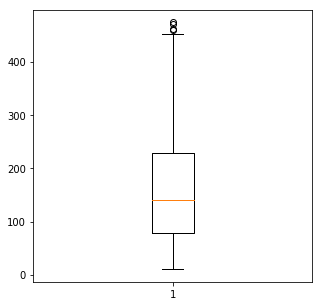

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(swiggy['length'])
plt.show()

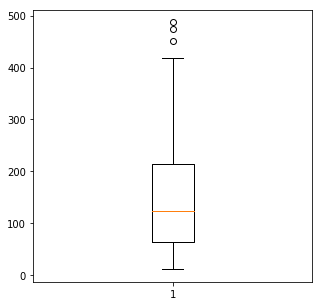

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(zomato['length'])
plt.show()

In [10]:
#Check sample tweets
swiggy['full_text'].sample(20)

464    @SwiggyCares Oh wow!! That's mighty exciting g...
177    @SwiggyCares What was the action on this @swig...
39     @SwiggyCares r from Rasoi restaurant butter pa...
159    @SwiggyCares How shameless are you @swiggy_in ...
265    @SwiggyCares restaurant sent me not what I ord...
27     @SwiggyCares I had a concern and I raised issu...
377    @SwiggyCares normally other service provider d...
144    @Trollborn1 @bharatnj2 @prasannacri @PandiyanD...
297                       @swiggy_in .4tl\n\nLl944o4more
621    @Harshaits @ZomatoIN @swiggyindia @swiggy_in H...
737    @WeAreSwiggy @swiggy_in @SwiggyCares Hello Swi...
643    @swiggy_in new way of doing things taking orde...
496    @SwiggyCares Have DM you! I have already recei...
267    I got a call back from Tanveer Ahmed. He promi...
119    @SmokingSkills_ @SwiggyCares Behrouz biryani? ...
250    REFUND OF KILLING OUR HUGER AND WORTH ORDER ~6...
102    @AnoopChathoth @SwiggyCares @swiggy_in @AnoopC...
50     @avinashNBK @SwiggyCares

<H2>Clean data</H2>

In [11]:
import preprocessor as p

stop_words = set(stopwords.words('english'))
stop_words_list = list(stop_words)

extended_list = []
with open('stop_word_extended.txt') as f:
    extended_list.extend([word for line in f for word in line.split()])

stop_words_list.extend(extended_list)
# stop_words_list.extend(stop_words_list.extend(['humans', 'water', 'may', 'nice', 'zomato',
#                                                'swiggy', 'order', 'food','delivery','customer','service',
#                                                'guy', 'time', 'says', 'days', 'shall', 'things', 'im', 'think']))
# stop_words_list = list(set(stop_words_list))

#remove stop words
def remove_stop_words(text) :
    word_tokens = word_tokenize(text)
    filtered_tokens = [w for w in word_tokens if not w in stop_words_list]
    return ' '.join(filtered_tokens)

#clean tweets for punctuations, numbers, # etc
def clean_tweets(text) :
    print(text)
    text = BeautifulSoup(text, 'lxml').get_text()
    try:
        text = text.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        text = text
    
    text = re.sub(r'@[A-Za-z0-9_]+','',text)  #remove all @mention
    text = re.sub('https?://[A-Za-z0-9./]+','', text)  #remove links
    text = re.sub("[^a-zA-Z\s]", "", text)  #remove all #, numbers, etc non alphabets
    text = text.lower().strip() #lowercase and strip
    text = re.sub(' +', ' ', text) #all double spaces with single
    
    text = text.replace('delivered', 'delivery')
    text = text.replace('deliver', 'delivery')
    text = text.replace('deliveryy', 'delivery')
    text = text.replace('customers', 'customer')
    text = text.replace('guys', 'guy')
    text = text.replace('boy', 'guy')
    text = text.replace('restaurants', 'restaurant')
    
    text = remove_stop_words(text)
    #text = p.clean(text)
    print(text + "\n\n")
    return text

In [12]:
#print original text and clean text
swiggy['clean_text'] = swiggy['full_text'].apply(lambda x: clean_tweets(x))

@Mahi_2510 @swiggy_in The ultimate answer will b sorry ... They assure that ...
ultimate answer b sorry assure


@SwiggyCares I hope so.
hope


@SwiggyCares I think you have the order details, was the number present there? If yea you can call right now.
present yea


@swiggy_in People are complaining here also, i know You are little disappointed by service, but for that you have customer service center or you can make direct messages, It is not necessary that every time everything is perfect, sometimes mistakes happens.
I think swiggy is best
people complaining little disappointed center direct messages necessary every everything perfect sometimes mistakes happens best


@swiggy_in Pls



@SwiggyCares Do you even know the meaning of your tagline, DM's won't work. I want explanation here.
meaning tagline dms wont work explanation


Nothing new, they had the most shittiest associates. You can expect these things from them on regular basis. @swiggy_in  Lets see how it goes. https://t.co/s

haha kartik behti ganga hath dho diye


@SwiggyCares @thevirdas Hey @SwiggyCares yesterday in BANGALORE, there was a rain and we thought the order wld get canceled. But your guy delivered the food in rain. You guys deserve appreciation too 🙏 keep up n keep serving 😀
yesterday bangalore rain thought wld canceled rain deserve appreciation keep keep serving


@swiggy_in I have ordered from my registered mobile number 7030157577. But not showing any updates on your app.. money already deducted
registered mobile showing updates app money already deducted


@thevirdas @swiggy_in One time i ordered wrong food ....cancelled in 10 seconds....still this swiggy bastard not refund my money....after that i never order from swiggy
wrong cancelled secondsstill bastard refund moneyafter never


@DunzoIt @kartikmittal17 @thevirdas @swiggy_in Mazze lena band karo.. Mera cigarette na deliver hua na.. Paise wapas mile uske.. Woh dekho.. Pehle.. It was my first order from dunzo.. 😂
mazze lena band karo mer

business theyre better redressal sham organization horrrible care


@SwiggyCares I tried manual entry but it doesn't work, so I thought it shall detect my location, but every time your delivery guy gets confused due to ineffective app location result. Please check.
tried manual entry doesnt work thought detect location every gets confused due ineffective app location result


@SwiggyCares Hey, just spoke 2 Tanveer who assured me that d issue is already escalated with Dominos ID 9883235 &amp; within 7-10 days I'd get back d money. Also he told domino's will give me a call by tomorrow. If this doesn't go well, then he asked me to raise this again here tomorrow. Thanks.
spoke tanveer assured issue already escalated dominos within money dominos tomorrow doesnt go asked raise tomorrow thanks


Shameful behavior @swiggy_in sent non-veg dish against listed veg item. Chat executive vanished and taking ages to solve the issue. https://t.co/UE021va6gD
shameful behavior sent nonveg dish listed ve


@SwiggyCares I faced same issue on today’s order... after waiting for 1hr now you have cancelled the order
faced issue todays waiting hr cancelled


@SwiggyCares @swiggy_in Why the hell have u kept the option of chat for support if your customer support executives are not going to respond only?
See for yourself below: https://t.co/IXBtoKV9JN
hell kept option support support executives going respond


@punitmalik69 @swiggy_in @SwiggyCares @WHO @Harshvardhanji @FCI_India @MCDdelhi @swiggyindia @harshamjty @nandanreddy @rahuljaimini @NaspersVentures @Naspers @BessemerVP @NorwestVP @Accel On top of it. Swiggy is becoming highly irresponsible. They say give negative feedback to restaurant and  they can't do anything. #BoycottSwiggy
top becoming highly irresponsible negative feedback restaurant anything guycottswiggy


@SwiggyCares (2/2) to mark it delivered. Why should the delivery guys then help if they have to suffer at the end? This is really sad! Plus, the seniors in the team weren’t a

ridiculous pepper chicken received chicken pieces handpicked ridiculous pay amount dish bluff


@SwiggyCares

441240197012 is my order id. 

Please ensure that there absolutely no onion as mentioned in the special instructions
ensure absolutely onion mentioned special instructions


@Devanginee @swiggy_in @Vaibhav17m @3Madhvi @friends4_eve @Star_roseR @yashgandhi66 @kapil_vinayak_ @BibinAlexander_ @Mehul_lm @SoulHackerAnkit @avii4ever This is really unaccepted from u very bad  service this is same things happen 3 rd time
unaccepted bad happen rd


@RachitDoshiYo @swiggy_in Got your DM, will meet you back there. Thanks!
^Pawan
meet thanks pawan


@SwiggyCares What the drastic service you guys provide, again another order cancelled delivery mentioning the same reason that he met with the accident..I think the process swiggy follow is order placed -&gt; picked up -&gt; driver met with accident.. it was my mistake to give another chance..
drastic another cancelled mentioning reason met acc

stupid pics carefully far better looser


#worst #experience with you @swiggy_in @SwiggyCares  every time when I order from you.
worst experience every


Is this worth you are doing with your #customer ? @swiggy_in 
#Deliveryboy took payment for butter Roti and ran away with the order. 
Paisa transfer karvaya or bhag gya order lekar..bola abhi aata hu..chahe toh dusre delivery boy se pucho jiske mutton deliver kiya.7906401876 https://t.co/glDzbgNcZQ
worth deliveryguy took payment butter roti ran paisa transfer karvaya bhag gya lekarbola abhi aata huchahe toh dusre se pucho jiske mutton kiya


@swiggy_in @SwiggyCares My order got misplaced with wrong https://t.co/fmkYfTRZpe is so pathetic. I ordered chicken biryani and you gave me mutton biryani.Too disappointing.And your customer service don't understand the https://t.co/DFCrp7zSw1 you expect me to pay for wrong item. https://t.co/01LWIbrG1V
misplaced wrong pathetic chicken gave mutton biryanitoo disappointingand expect pay wrong item





@abhijeetdhillon @SwiggyCares @swiggy_in Talk about making a mountain of a molehill. How does expected cost ₹1 bug affect you in any way. Or are you dumb enough to believe that the avg cost of 2 at this restaurant was really rs 1
talk making mountain molehill expected cost bug affect dumb enough believe avg cost restaurant


@HeavenDeBruyne @SwiggyCares @swiggy_in Well in this case, the next time the Government of your country makes a mistake or does something wrong rather than pointing it out you should run for the elections. #PleaseBeLogical
case next government country makes mistake something wrong rather pointing run elections pleasebelogical


@SwiggyCares
I've found this on #OLX. What do you think? Swiggy hiring delivery boya https://t.co/uNGWWf8PnL
ive found olx hiring guya


@SwiggyCares Sure will do. From your end stop pressurising your partners with incentives for more deliveries. That's one way of solving the problem. Can you do so much?
sure stop pressurising partners in

telling refunding amount


We are the manufacturer of all kinds of sportswear and we are helping brands to promote their businesses by branding their firm on clothing stuffs like t-shirt and all. 
@Zomato @zomatocare @ZomatoIN  @swiggy_in  @swiggydesign @rapidobikeapp @Olacabs @Uber_India @yamigautam
manufacturer kinds sportswear helping brands promote businesses branding firm clothing stuffs tshirt


@swiggy_in @SwiggyCares  Cakes accepted the order but didn't have the product &amp; the replacement cake charged Rs 100 more. Thanks to Mr. Mahesh Shaw he made the delivery possible, as we were going to surprise my sister on her birthday &amp; was running out of time before she returns. https://t.co/u5jWuS5QtP
cakes accepted product replacement cake charged thanks mr mahesh shaw made possible going surprise sister birthday running returns


@SwiggyCares promised me “a better experience in the future” just yesterday, and we have another mishap on our hands again today. Is there an end to t




@swiggy_in pathetic service, ordered 8 Chapati and it took almost 1hr to deliver and your delivery executive doesn't picking up the call. 
#pathetic #service #horible won't suggest anyone.
pathetic chapati took almost hr executive doesnt picking pathetic horible wont suggest anyone


When u r hungry n then u order from @swiggy_in @SwiggyCares  n then u get A big dal with a single roti in a so called spl combo.. Useless ...

-Amit 9022316433 https://t.co/ogCKUx4pgR
r hungry big dal single roti called spl combo useless amit


@swiggy_in Pathetic customer service Ankur Ghosh Ravi from chat please respect your customers you are getting paid for that only!!
pathetic ankur ghosh ravi respect paid


@SwiggyCares Nice 👍🏻



@SwiggyCares Your app has a list of restaurants. There should also be a restaurant address. @swiggy_in
app list restaurant restaurant address


@zomatocare @utred06 @btppubliceye @blrcitytraffic @swiggy_in @Zomato It’s one thing to claim this on twitter. Reality on the g

cancelled reinitiated refund joke


@swiggy_in You are not helping and understanding the severity of the issue in DM
helping understanding severity issue


@swiggy_in @SwiggyCares https://t.co/suWoReTW45



@SwiggyCares @swiggy_in Where is my order????



@SwiggyCares @swiggy_in You are not helping in DM dear..
helping dear


@iAnuraGautam @swiggy_in Anurag, we apologise for the let down in service. We do have you in DM, request you to meet us there further assistance. 

 ^Aravind https://t.co/EhSzF4Z01R
anurag apologise let request meet assistance aravind


@swiggy_in @SwiggyCares  You need hair? Come..I still have your order with me https://t.co/MFQX2u5e7l
hair comei


@datsvjt @SwiggyCares @swiggy_in Me too



@SwiggyCares We order food from you that means we trust you. But don't break our trusts like this. If I was careless that you will refund me automatically then it was my big mistake. Customers are like god so don't cheat with your god. Thanks for resolving this issue.
means tr

everyone wan na steal broad daylight step open app step paid promotion step cancel refund step never refund emails sounds similar


@SwiggyCares The issue was that concerned restaurant called me that they don't have the order item being displayed and then the order got cancelled with a deducted cancellation fee? Why when the order dint go through
issue concerned restaurant called item displayed cancelled deducted cancellation fee dint go


@swiggy_in saved the day on my vacation in goa.. With crappy hotel food, it was your app that worked beautifully with great variety of restaurants and brilliant delivery #Kudos #yourthebest
saved day vacation goa crappy hotel app worked beautifully great variety restaurant brilliant kudos yourthebest


@SwiggyCares They guy has initiated the refund, and I have already ordered again just to give it another try before I move on. I haven't received the refund for my cancelled order, hope I will in some time.
initiated refund already another try move hav

cwc engvsind win predictor changed changed minutesafter let change per runrate weather etc


@SwiggyCares not content with the resolution.
Will refrain myself from using swiggy.
Won’t renew my super membership as well.
content resolution refrain using wont renew super membership


@SwiggyCares That’s fine but have to thought about the person who was hungry and ordered food and got this.... he has to order again which is again 30-45 mins delay... really??? You are hungry and waiting for 2 hours ??? How will you justify and compensate that??? Nothing just refunding !!!!
fine thought person hungry mins delay hungry waiting justify compensate nothing refunding


@nakli_chashmish @gandapela @mahan_saria @swiggy_in @SwiggyCares आप से गलती नही होती जिंदगी में तो आगे बहस करेंगे अन्यथा चुप चाप खा लो 😊



@SwiggyCares Thanks for responding I did a help ticket in your app.
thanks responding ticket app


@swiggy_in You suck!!! https://t.co/MbvvrHzXjo
suck


@SwiggyCares @swiggy_in pathetic deliver

bad orderd status actually pickup solution


@SwiggyCares and this after i was given a poor quality order, and swiggy had called and promised a resolution in 2 days. Pls check call records, even your rep who called me agreed the quality was extremely poor. #cheats #liars #poorservice #badqualityfood #swiggycheats
given poor quality called promised resolution records rep called agreed quality extremely poor cheats liars poorservice badqualityfood swiggycheats


@SwiggyCares it is Nitin ..Can’t you guys even spell name correctly??? https://t.co/cwqEukiEGQ
nitin spell name correctly


@swiggy_in Please pass on my thanks and gratitude to the rider who delivered  order #43941884430 in pouring rain in Ahmedabad. Thank you :)
pass thanks gratitude rider pouring rain ahmedabad thank


@swiggy_in plz help and share https://t.co/013YEbxs3M https://t.co/V9J5KFAlY4



@UberEATS @UberEats_IND may I know how  @swiggy_in  driver partner  founded the @Oven_Story restaurant and deliverering the same. A

oh reach either hunger tinged certain grudging respect zero fs attitude life enjoy fries man enjoy fries


@SwiggyCares exceptional crap of a service -  #44640781249 https://t.co/hPw0F0fMf7
exceptional crap


@swiggy_in  my order keep getting delayed... What the hell? https://t.co/Xb242WvJIZ
keep delayed hell


@SwiggyCares 9872491881 Registered number
registered


@SwiggyCares Please call me on 9773225812 I'll give you all the details there.
ill


@SwiggyCares Why DM to hide your mistake. First explain the reason why this happened.
Let Down is nothing = YOU HAVE MADE ME CRY
hide mistake first explain reason happened let nothing made cry


@swiggy_in @SwiggyCares how do you conduct your hygiene audits??
Fly found in my pizza ! From Square pizza. https://t.co/5iqKdXn1dU
conduct hygiene audits fly found square


Fantastic idea by Mangaluru MLA @vedavyasbjp . Convince restaurants and services like @SwiggyCares to shift to banana leaves for their dry food packing. @prajwalmanipal reports f

worst ive ever raw uncooked rice quantity appalling paid unfortunately star rating isnt enough pop joke fourth tagging two weeks whats going


@parthiselva247 @SwiggyCares @swiggy_in Now just Cancel the order to give @SwiggyCares a fitting reply..Online food providers have no complaint-redressal mechanism at all..They r just limited to "Default reply" which requires a simple "copy-paste".
cancel fitting replyonline providers complaintredressal mechanism allthey r limited default requires simple copypaste


@SwiggyCares How shameless are you @swiggy_in @SwiggyCares https://t.co/gs8noh0jy5
shameless


@FirstpostSports @firstpost @MdShami11 Hey @UberEats_IND looks like @FirstpostSports is hungry.. can you help them or should I also ask @swiggy_in and @ZomatoIN to help
looks hungry ask


@SwiggyCares I have dm'd y'alll... No response tho..
dmd yalll response tho


@SwiggyCares So you are saying, it has nothing to got with swiggy with the packaging charge.
nothing packaging charge


@Swiggy

sucks channel hotel india mutton register complain along w raising issue


@ChaifullyYours Ordered ginger tea through @SwiggyCares the tea was neither hot nor it tasted like ginger tea.We have been a regular customer of yours but this time terribly upset with your service
ginger tea tea neither hot tasted ginger teawe regular terribly upset


@SwiggyCares @swiggy_in this is how you are dealing customers?? And you expect people to order from you?? https://t.co/lOex9gKyjJ
dealing expect people


@swiggy_in if you cannot deliver please don’t take take order &amp; remove your tag line. #SayNoToSwiggy #Disgustingservice #NeverDeliver https://t.co/AZ3SkbuAXs
remove tag line saynotoswiggy disgustingservice neverdelivery


@SwiggyCares Awaiting the D-Day ........
awaiting dday


Impressed with @swiggy_in automation!
impressed automation


@arian_earthling @swiggy_in Yeh to akshay khanna ka order sunny deol me gaya tabhi bol raha hai ki ghar kab aaoge
yeh akshay khanna ka sunny deol gaya tabhi 

providers disappoint serve worse returning thanks serve existing


Monna evaro swiggy delivery boy varsham lo kuda pani chestunnadu.. Thopu thurum annaru..

@swiggy_in vaadu ventane we are committed to customers thotakoora ani build up ichadu..

@SwiggyCares vaadu delivery boys ki iche reward idhi🙄🙄🙄

https://t.co/7UNCxxZAJz
monna evaro varsham lo kuda pani chestunnadu thopu thurum annaru vaadu ventane committed thotakoora ani build ichadu vaadu guys ki iche reward idhi


@SwiggyCares Order id 42548899979



@SwiggyCares I want you to make understand your representatives that customers must not be taken for granted...You also if this would have been an issue in another country what consequences would you guys be dealing with.
representatives must taken grantedyou issue another country consequences dealing


Over two days, techie Pratyush Kumar used @swiggy_in to deliver food to 15 customers and #Rapido to drop 10 customers to their location #Bengaluru

@AshwiniMS_TNIE @NewIndianXpress 

full refund half amount coupon


@SwiggyCares @swiggy_in @PMOIndia @narendramodi @FinMinIndia @ianuragthakur @UberEats one restaurant one item different gst 🤣🤣 howz it ? #corruption #swiggylute sir ye log janta ka paise lut rhe he https://t.co/slBrJUSShT
restaurant item different gst howz corruption swiggylute sir ye log janta ka paise lut rhe


@suchetadalal @sanjayuvacha @SwiggyCares Thats why i was forced to delete @swiggy_in @SwiggyCares i m having good experience with @ZomatoIN much better than swiggy
forced delete good experience better


@SwiggyCares
My order:  42530480204 .
I have received 4-5 days old a very bad taste lassi
received old bad taste lassi


@suchetadalal @SwiggyCares Aggregator business models loose control of customer service processes due to fast expansion and degenerate over time. Ola, Oyo, Yatra are on similar path....
aggregator business models loose control processes due fast expansion degenerate ola oyo yatra similar path


@suchetadalal @SwiggyCares @Uber

kind shit fucking


Hi @SwiggyCares

Please explore if it's possible to offer granular customization on your website, in case of certain food items, where some of your audience might prefer, spicy, medium spicy, non-spicy etc varieties.

Spicy is a relative concept, but I guess non-spicy is not.
hi explore possible offer granular customization website case certain items audience might prefer spicy medium spicy nonspicy etc varieties spicy relative concept guess nonspicy


@swiggy_in I don't need to describe my love for my father. He is the bestest 😻
describe love father bestest


@swiggy_in feels sorry but don't care about money because you can't do anything after delivery @SwiggyCares https://t.co/8aiALm6iGc
feels sorry care money anything


@swiggy_in My dad ia my world . Love you dad
dad ia world love dad


@SwiggyCares I'm sure this twitter handle also is too lazy like their customer support to respond or to take an action
sure twitter handle lazy support respond


@swiggy_in thank

leaked already


@SandipThink @SwiggyCares I have made a lot of complaints to their customer care, but all that they do is process refund. But they do nothing about the quality of service or the vendor or the food.
made lot complaints care process refund nothing quality vendor


@swiggy_in @SwiggyCares  this is what I will do I won't cancel the order next time I will just not receive it https://t.co/x87qp36k1U
wont cancel next receive


@swiggy_in @SwiggyCares it's been almost an hour and no delivery executive has been assigned on my order that is only 5 minutes away, this is very disappointing. https://t.co/xCdTn4OW1l
almost executive assigned disappointing


@SwiggyCares Order ID is 48360692936 ordered from Aleeshaa's Yummy Indian
aleeshaas yummy indian


@SwiggyCares Again @coolwinks_com watch and learn! 👆🏼
watch


@robinpamnani @zomatocare @swiggy_in and @Zomato r in race to outdo each other
r race outdo


@SwiggyCares Dude that was a compliment for you. Don’t bother ... u guys are

going anything fool


@swiggy_in @SwiggyCares Am a super member,either Swiggy sends rotten chicken or items will be missing,in my recent order I have paid for meat balls but not received,when I reported the issue to swiggy customer care I got only apologies not the missing food items.Cheating company
super membereither sends rotten chicken items missingin recent paid meat balls receivedwhen reported issue care apologies missing itemscheating company


@SwiggyCares Already paid extra money but no use.... https://t.co/o5yMn2ccu8
already paid extra money


@SwiggyCares If you know that restaurants are levying different prices for their online orders, then why should you accept those restaurants and kept in online. you reject it or make them keep same prices as dine-in businessess.
You are supporting those restaurants and cheating the customers.
restaurant levying different prices online accept restaurant kept online reject keep prices dinein businessess supporting restaurant cheating


@P

thanks quick resolution something integration rd transaction failed amount credited automatically week keep bugging


To all food Deliveryg partners kindly update all the App's With providing a one option like weather the is available or not (with an pop Button in the App) by diving it into avalible or not.
Hope for best results

@swiggy_in @Zomato @UberEats_IND
deliveryg partners update apps providing option weather available pop button app diving avalible hope best results


@SwiggyCares  is it the way to deal with the customer?"no response" https://t.co/p7vCjg4aQg
deal customerno response


@swiggy_in @SwiggyCares  ordered qt 1.33 when it showed delivery time 37 mins. Its 2.37pm now https://t.co/GsEoK4Jw0K
qt showed mins


@Zomato @zomatocare are u guys on long leave??? Don't even bother to respond!!! I guess time to shift to @swiggy_in ...so my next order wud b through them
long leave bother respond guess shift next wud b


@swiggy_in What’s wrong? Why is every restaurant unservice

tell anything done hungerness caz gon na cancel whole night suffer


@swiggy_in congrats on the tremendous improvement you managed to get 1 out of 3 orders right. Thanks! Closing the customer support conversation before hand was also great.
congrats tremendous improvement managed thanks closing support conversation hand great


@SwiggyCares My friend ordered Paneer for me and you guys delivered me chicken! https://t.co/1k8KNzOhKu
friend paneer chicken


@SwiggyCares Order ID - 43689083183 - half of the order delivered, main breads missing and your chat agents response as fast as the solution provided - replacement! For a dinner why don't you split my meal into next day breakfast and lunch?
half main breads missing agents response fast solution provided replacement dinner split meal next day breakfast lunch


@swiggy_in  i am super swiggy user but no any order after super swiggy , regret  super swiggy ko koi free delivery k alava not benefit i never next time super swiggy....Not satisfi

charged rupees packing


@SwiggyCares We didn’t receive any order confirmation, order wasn’t placed in the first place to begin with. And the money was deducted.
receive confirmation wasnt first place begin money deducted


@harshamjty 
Have a look on Swiggy costumer service.#swiggy 
@swiggy_in 
@SwiggyCares 
@WeAreSwiggy https://t.co/y8xELB2nhs
costumer serviceswiggy


@SwiggyCares We haven’t received any order details - no order confirmation , order hasn’t been placed and the money was deducted.
havent received confirmation hasnt money deducted


@SwiggyCares Meanwhile I'll be waiting for the #government to allow outside food in #maharastra atleast.
meanwhile ill waiting government allow outside maharastra atleast


Honestly this is so frustrating. Too bad! @swiggy_in @dominos_india. I legitimately have the proof.  This is what my friend ordered.  And just  afew moments later there wasn’t any order confirmation received. What nuisance is this!! https://t.co/v6po5ioUpa
honestly frustr

issue related coupen code payment complaining since afternoon executives nit able resolve treat


@swiggy_in @swiggy_in @SwiggyCares @WeAreSwiggy



Hi sir from next month i. e in July we heard some rumours that the order amount is going to be reduced to 28 rupees per order. Kindly pass a statement regarding this @harshamjty @swiggy_in
hi sir next month e july heard rumours amount going reduced rupees per pass statement regarding


@swiggy_in  Cancelled my ORDER #42456790277 without trying to call me on my number,even delivery guy confirmed same...on calling CC...they  r saying feed Guests with apologies we delivered ...Great service
cancelled trying numbereven confirmed sameon calling ccthey r feed guests apologies great


I am a super member of @swiggy_in and I just realized they have started delivering in my area (some 30 kms away from main Jaipur city/my office). A boy says thank you 🙏
super member realized started deliverying area kms main jaipur citymy office thank


@SwiggyCares

facts society specially tn temples sabarimala allow women mensuration comes girls jus b entering mensuration taken serve temple life answer coz culture start hypocrisy


@SwiggyCares @ManoharChinnam @SwiggyCares don't flirt with men now.....🙄
flirt men


@swiggy_in Navdurga Foods is 10 times faster than #Swiggy
navdurga foods times faster


@SwiggyCares Can you please tell me what is DM????? At this hour you are requesting me this??
tell requesting


@zomatocare,@ZomatoIN ,@swiggy_in i have ordered from zomato and paid the amount but i call in the resturant,they r closed as they told..this type of service zomato is giving.kindly refund the money back soon. https://t.co/WJBgAbj0GA
paid amount resturantthey r closed toldthis type givingkindly refund money soon


@OYERJALOK @swiggy_in @SwiggyCares Fraudster
fraudster


@swiggy_in Plz return my cash435
return cash


@swiggy_in @SwiggyCares Two back to back orders 1)44907098008-had to cancel because the delivery guy didn't deliver, 2)449102

dp mentionedcall


@akshaytawhare @swiggy_in @ZomatoIN @FDAfood Now compare their price with the restaurant menu card. You will be surprised to see the difference
compare price restaurant menu card surprised difference


@SwiggyCares 44890645605
M:9634755516

I don’t want to remain a SUPER member of your platform anymore. So, please initiate a refund of my membership
remain super member platform anymore initiate refund membership


@SwiggyCares Not sure, what you would do now though. I'll DM you, and by the way I've taken a print of the refund email so that I can eat it. 😁
sure though ill ive taken print refund email eat


@swiggy_in @SwiggyCares @SRIHARSHAMAJETY your executive said to me we credited 100rs coupon where is my coupon https://t.co/3WJKC4UEkN
executive credited coupon coupon


@nefermynd @ZomatoIN @swiggy_in @faasos Hi Kunal! We’re very sorry for the trouble caused. Kindly share your 10 digit order ID and we will get this checked right away. ~RS
hi kunal sorry trouble caus

sorry apologies copy pasted matter looting


@SwiggyCares Hey Guys, what was wrong with your service at Delhi NCR today. Ordered twice. Once for lunch and one for evening snacks but the order was quite delayed... No complains just checking..
wrong delhi ncr twice lunch evening snacks quite delayed complains checking


Worst experience with @swiggy_in @SwiggyCares amount debited and food not delivered cancellation charges deducted without my fault. #uninstall_swiggy from phone.
worst experience amount debited cancellation charges deducted fault uninstallswiggy phone


Still showing 12 mins. Wtf??? @SwiggyCares @SwiggyCares ????
showing mins wtf


@subhendubhatt @swiggy_in @RBI It's so true. They take hell of time for refund. They don't have any proper channel which would drop mail or text with transaction id once the refund is initiated. And then they say we have inititaed from our end contact your bank. Need to follow up 100 times for refund. Poor
true hell refund proper channel drop t

change name doesnt care care sucks


@bogas04 @rajpal_saurabh @swiggy_in No worries! I did order at the next slot of 7 pm.
worries next slot


@swiggy_in 43599867140 was not delivered after 90 minutes and finally cancelled.. chat executive are poorly trained.. worst experience even after having superswiggy..@jagograhakjago please take some strict action. They should compensate
finally cancelled executive poorly trained worst experience superswiggy strict compensate


@SwiggyCares Your #technology is waste.. not even able to predict a delivery time as your #executives are not trained and equipped.
This was my #lastorder from your App #uninstall #swiggy ...every time I order.. only get to #suffer like such #issues @swiggy_in #swiggy #fooddelivery
technology waste able predict executives trained equipped lastorder app uninstall every suffer issues fooddelivery


@SwiggyCares I hope your words are followed by ACTIONS
hope words followed actions


@SwiggyCares Order #43603517534. The app sa

cockraches lazeez thru


@ideasmithy @swiggy_in Another common "swindle" is that the actual value of the discount applied is often lower than what the *Swiggyit* promo code mentions.
another common swindle actual value discount applied often lower swiggyit promo code mentions


@swiggy_in is full of cheat. Deleting #Swiggy app right away. I got a smosa and jalebi from my next door outlet at the outlet price with no packing charges. #SwiggyChor is making ppl fools and blame vendors on packing charges. Also fr 15 rs item swiggy charging 55 delivery https://t.co/Af4TsZ7gyi
full cheat deleting app smosa jalebi next door outlet outlet price packing charges swiggychor making ppl fools blame vendors packing charges fr item charging


@SwiggyCares @swiggy_in want to say you that I'm getting the worst experience from your app now.
Waiting for the food to be delivered for past 2 hours. #Congrats and keep it up.
worst experience app waiting past congrats keep


Dear @SwiggyCares &amp; @swiggy_in 




@FasterMK @swiggy_in अब फिर से सब समझाना पड़ेगा।
भूल गए होंगे इतने दिन में तो 😜😂😂



@SwiggyCares @_y2cry Do let us know,as to what action have you taken. So this sets as an example for others. A simple warning won't work .
let knowas taken sets example others simple warning wont work


@SwiggyCares very disappointing experience after 20 mins screen pops up and say order awaited from restaurant confirmation when called cc after hanging up order gets cancel atleast have a courtesy to call customer. Or else stop the service.  Time waste app.
disappointing experience mins screen pops awaited restaurant confirmation called cc hanging gets cancel atleast courtesy else stop waste app


@SwiggyCares order no 43513197668 received bad quality of pizza https://t.co/xNhzS8nyu0
received bad quality


और @swiggy_in वाले कुत्तों कैसे हो, मेरे 300 रुपये कब दोगे हरामजादो 😡😡😡😡😡😡😡



@SwiggyCares Order id @SwiggyCares https://t.co/tfForJO7fM



Dear @swiggy_in ,

Just wanted to inquire if the food is

poor provided proper response care side various grievances hand fantastically


@AthiraMadhav @CafeCoffeeDay @swiggy_in @SwiggyCares What a fraud!
fraud


@Kyathamomkar @swiggy_in @SwiggyCares Similar stuff happened with me, the order was cancelled by swiggy
similar stuff happened cancelled


What's happening @swiggy_in @SwiggyCares stop regretting and take action. https://t.co/rpuepySpcx
whats happening stop regretting


@swiggy_in Bakwas
bakwas


@SwiggyCares Please dun send me template messages. I know the templates that u use....I am fed up of such messages from your side. Ask ur founders to stop relying on your apologies and start working for bettering the operations and customer experience.
dun send template messages templates usei fed messages side ask founders stop relying apologies start working bettering operations experience


@SwiggyCares Hello https://t.co/lOz8A3jSML?
hello


Why are Indian managers so successful at global companies? With a little help from a recent book o

chor


@swiggy_in chor2
chor


@swiggy_in chor1
chor


@swiggy_in chor
chor


@renaissance1221 @swiggy_in Got you in DM , assisting you there.

^Amisha
assisting amisha


The advertisement of @swiggy_in is way more entertaining than the lousy batting of Pakistan.
@StarSportsIndia @cricketworldcup #ausvpak #CWC19
advertisement entertaining lousy batting pakistan ausvpak cwc


@swiggy_in you got the worst service. Atleast get your map corrected.
worst atleast map corrected


@swiggy_in @SwiggyCares https://t.co/N7SKQCyhWr



@harshamjty @swiggy_in @SwiggyCares  feeling sorry for being your exclusive partner for even small menu updates i have to wait for months and today for your team has switched off my major selling items giving me huge finacial loss who will bear this loss? Rest id 26297 20788 5300
feeling sorry exclusive partner small menu updates wait months team switched major selling items giving huge finacial loss bear loss rest


@swiggy_in pathetic food delivered..pls initiate r

little specific response expected timeline resolution


@SandipThink @SwiggyCares Thats true...  I guess...  Because for the pain i am in...  They are offering me 75rs coupon...  Does ur monry solve my pain or does it pay my medical bills...  I clearly want an apology from the restaurant owner.  SIMPLE
true guess pain offering coupon monry solve pain pay medical bills clearly apology restaurant owner simple


@SwiggyCares @RiddhimaKartik Don't expect any resolution from them.... They are experts in such type of services
expect resolution experts type services


@UberEats @ZomatoIN @swiggy_in Which app does not provide receipt for cancellation charges. The answer is @UberEats  .  They charged me Rs 204 without any receipt. Account shows it not charged. https://t.co/SrmsBYftTJ
app receipt cancellation charges answer charged receipt account shows charged


@SwiggyCares I have invested everything from my side... Now its upon you guys if u want to help or not
invested everything side upon



thanks executives serve heavy rain


@SwiggyCares Stop replying with your useless messages!! If you can, call me and sort the issue.. Or else stop disturbing me! Anyhow this would be the last time I'm using swiggy!
stop replying useless messages sort issue else stop disturbing anyhow using


@swiggy_in @SwiggyCares customer means anothing to you. All that matters is computerized response and some replies to shut the consumer. I want a cash back for this. I can't eat this. #swiggysucks
means anothing matters computerized response replies shut consumer cash eat swiggysucks


@priyankvadhan12 @swiggy_in @SwiggyCares @UfterYou The restaurant don't charge extra for packaging when ordered directly to them .
restaurant charge extra packaging directly


@swiggy_in @SwiggyCares In spite of teeling instructions. In spite of informing the customer care, in spite of saying its been repeated they do it. I say no vegetables and this happens. #swiggysucks https://t.co/n2F7ogpOCZ
spite teeling instruc

sorry


@swiggy_in @fssaiindia @JagoGrahakJago_  This is really annoying and not acceptable . I have ordered food from Swiggy and after ~40 minutes I got a call from the delivery boy saying someone else has taken your order and I can’t help and disconnected the call https://t.co/FgluSAs3OR
annoying acceptable someone else taken disconnected


@SwiggyCares I have order food in dindigul thalappakatti restaurant I received my food completely no safety and not all packed properly how can I believe this is belongs to that restaurant and healthy to eat ? https://t.co/HUqvZLUg2R
dindigul thalappakatti restaurant received completely safety packed properly believe belongs restaurant healthy eat


@swiggy_in @SwiggyCares please take strict action on these @dominos_india Patia guys. If they gave very less priorities swiggy order y shud i order through swiggy.
strict patia gave less priorities shud


@SwiggyCares. Sorry.. I tried to try something else.. You owned me.. I had issue with you.. But yo

restaurant owners comment discrepancy per price jacking restaurant confirmation itll clear culprit


@SwiggyCares hey there um not able to place any order due to technical issue...kindly resolve it..
um able place due technical issuekindly resolve


@sharat200 @Zomato @swiggy_in @UberEats Zomato is worst.. In terms of food delivery.. Never opt for it.. #Pathetic
worst terms never opt pathetic


@jaimin_gandhi @SwiggyCares Yes now swiggy is giving wrost service
yes giving wrost


@SwiggyCares It's a request from my side to let me know what corrective action you are going to take or taken for the same case.
request side let corrective going taken case


@UberEats_IND @UberEats they denied to contact delivery boy and gave no reason why they did this.if there is our mistake of placing wrng order and we cancel it they are charging amount of the order now who's mistake is this?  Seriously @ZomatoIN  and @swiggy_in  are far better.
denied contact gave reason thisif mistake placing wrng cancel

something went wrong


@SwiggyCares Done with DM. It's not called Sub-par experience, it's called harrassment and loot.
done called subpar experience called harrassment loot


@SwiggyCares Can I expect a decent reply here? Which really meant to resolve the concern , instead of being sorry for nothing
expect decent meant resolve concern instead sorry nothing


@swiggy_in @SwiggyCares 

Please look into this matter as soon as possible https://t.co/4XxzpGj2kD https://t.co/28mw3jEA1z
matter soon possible


@golazynani @SwiggyCares @swiggy_in Yea was expecting a much smoother experience, support guy simply said "won't happen in future", I was like "dude who cares about your future, what do I do now? You have seen the pic and you expect me to eat it!!?" And he simply said he can't do anything!!
yea expecting smoother experience support simply wont happen future dude cares future seen pic expect eat simply anything


@swiggy_in , @SwiggyCares https://t.co/4XxzpGj2kD https://t.co/BLRychIB3n




month following refund solution


@bengalurean_ @swiggy_in @ZomatoIN Wow!😳😳😳
wow


@ArunBee @SwiggyCares You might be Sridevi in yester life
might sridevi yester life


@swiggy_in - I see you slowly increasing prices of items by Homely. A gradual step-by-step increase.
slowly increasing prices items homely gradual stepbystep increase


@SwiggyCares booked an orerder and made payment using UPI option . Money got deducted 2 times but order failed.
booked orerder made payment using upi option money deducted times failed


Which one is authentic.. Egg curry or boneless egg curry..?? 🤣🤣 @swiggy_in Please guide me.. 
@SwiggyCares
#Swiggy https://t.co/OFsI6kXNGk
authentic egg curry boneless egg curry guide


@swiggy_in @SwiggyCares I ordered a combo from this local restaurant corner. It included masala papad which is their signature and cost 50 rupees individually. Though the combo included it which it states on the app,it was not delivered. Pl confirm with restaurant and get back.
combo loca

idiot online


@RhikKundu @pranavmukul @swiggy_in And enrol with Swiggy to start tiffin service and then charge exorbitant delivery fee. Life will have come a full circle.
enrol start tiffin charge exorbitant fee life come full circle


Today's #Infrastructure news featuring @AppyParking + @teleportHQio + @GobiPartners + @easyParcel and @swiggy_in 🏗 Access our #ImpactInvesting platform today → https://t.co/KFpKvov0TV https://t.co/7tGrAWLbQI
todays infrastructure news featuring access impactinvesting platform


@SwiggyCares Dm me your email Id so that i can complete my complaint to consumer forum..we can take legal notice and legal action thereafter
email complete complaint consumer forumwe legal notice legal thereafter


@swiggy_in WILL YOU CARE TO REPLY   ??????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????  @SWIGGYCARES
care


@swig

old habit deliverying offering coupons beggars listen issues else stop pretending care


@SwiggyCares hopeless service today in Jakkur plantation road Bangalore,first time when I ordered today evening the delivery executive started lying that he is not finding the restaurant and second time when I ordered after half n hour the executive picked up food stated same
hopeless jakkur plantation road bangalorefirst evening executive started lying finding restaurant second half executive picked stated


Received food in this condition thnxs very much @SwiggyCares @swiggy_in !! https://t.co/byiDtj6nFO
received condition thnxs


@swiggy_in @SwiggyCares first of all at 11 am you send spoiled food and then deny to replace it. 
Order id 46456908720
first send spoiled deny replace


@SwiggyCares Problem solved. Refund generated. But I'm still hungry 😭. It has been 3 days 0 @swiggy_in
problem solved refund generated hungry


@SwiggyCares Any update
update


@SwiggyCares No reply anyway 🤷🏻‍♂️
anyway


hello


@SwiggyCares  Ticket no. 5611587 pending with your partner support team since 26th June.  Every time I call they delay further.  Till today both the issues raised in the ticket still pending. Extremely sorry to mention that Zomato is million times better in serving their partners
ticket pending partner support team since th june every delay till issues raised ticket pending extremely sorry mention million times better serving partners


@swiggy_in your services are pathetic and your customer care executives are most arrogant and misbehaved individuals hired for this kind of Job. Wrong items are delivered every second day. No resolution from customer care executives other then part refunds.. order#45248561279
services pathetic care executives arrogant misbehaved individuals hired kind job wrong items every second day resolution care executives part refunds


Ordered something off @swiggy_in because I was insanely hungry after the @BeCureFit session (and ghar par dal roti bani th

waiting


@SwiggyCares Hi Priya, just now received a call from Mazhar. The order has been delivered. Mazhar was very helpful and I would really like to appreciate the way he handled this. Thanks.
hi priya received mazhar mazhar helpful appreciate handled thanks


@swiggy_in Contacted customer service 3 times for a coupon related issue, reinstalled app, relogged in twice, it has been two days, still my issue isn't resolved. Please don't say "yes" when they offer you coupons for some order issue. Ask for refund the very moment.
contacted times coupon related issue reinstalled app relogged twice two issue isnt resolved yes offer coupons issue ask refund moment


@SwiggyCares @Hasneen_Shereef You talk like your delivery partners are face of your company but you don't even take care of them. Fleet managers doesn't care about our problems, they don't give proper resolutions. If there were no enough orders, why did you hire new one?
talk partners face company care fleet managers doesnt care p

yes took long good chance replaced agent users beware


.@SwiggyCares is so amazing that it marked an order delivered without delivering and instead of asking their delivery guy why he marked it delivered, they are asking me why I waited for 2 hours to contact.
amazing marked deliverying instead asking marked asking waited contact


Order #44206273014
Uninstalling @swiggy_in and @GooglePayIndia right now.....It's been weeks but cashback issue is still not resolved. Swiggy teams asks to contact GooglePay which is difficult to reach.

Useless apps with useless support staff.

@SwiggyCares @GooglePay
uninstalling nowits weeks cashback issue resolved teams asks contact googlepay difficult reach useless apps useless support staff


@SwiggyCares Are you not able to find my number or not able to find an active phone line?
able find able find active phone line


@Iamanuraggupta @VikasJa84310971 @swiggy_in @ZomatoIN they pay 50 rupee to delivery guy. so its doesn't mean that the charges is righ

worst experience ever sent conversation snapshots require immediate


@SwiggyCares 9008475338 is the registered number
registered


@swiggy_in @SwiggyCares hi all , pls do not order anything from swiggy as they are frauds , they accept order and shows deliver without delivering it and they charge also
hi anything frauds accept shows deliverying charge


@SwiggyCares He made me wait for 1 hour and then informed that food item is not available. This is terrible terrible service.
made wait informed item available terrible terrible


@SwiggyCares U are at liberty not to help while I am at liberty to take preventive steps which I believe are against public health. If u have anything to say u can write to me on email (available with my order no)  I do not want to any calls. Also what prevented u all from sending a DM?
liberty liberty preventive steps believe public health anything write email available calls prevented sending


@swiggy_in @SwiggyCares your customer care idiot did not do his 

probably change twitter handle name doesnt care care representatives manners whatsoever agents respect clients


@SwiggyCares I had a pretty bad experience today while ordering food after ordering pizza your customer care called me up after 2 hrs to say that restaurant has been closed
pretty bad experience care called hrs restaurant closed


@SwiggyCares Thankyou so much for your gesture. Expecting the discount coupon soon.
thankyou gesture expecting discount coupon soon


@swiggy_in @SpinGreat This is typical of swiggy. When they get caught red handed on MRP stuff they blame the restaurant because they are only the "delivery partner", they don't care if restaurants scam you out of your money.
typical caught red handed mrp stuff blame restaurant partner care restaurant scam money


@Anoop_Payyannur @SwiggyCares @swiggy_in Well the one consistent thing is that they are terribly sorry and it's not their fault but their system. Bhai tumhara system tumne bnaya hai ki Uber eats ne?
consiste

done support responding become cold waste money revert


@swiggy_in @SwiggyCares i ordered food from swiggy 
i was starving af so i ordered from highly rated restaurant but it came to be worst decision as the food was stinging smells like rotten . whole food is still in plate smelling haven't touched it.
#45848656590 is that order no
starving af highly rated restaurant came worst decision stinging smells rotten whole plate smelling havent touched


@SwiggyCares @swiggy_in placed order and 9 PM it's 1025 PM now..still showing food is being prepared..wrong info being given the del executive has reached..whereas he had not..why bluff..faced similar issues earlier as https://t.co/G7M7WMBf2b one seems to be monitoring..poor show
nowstill showing preparedwrong info given del executive reachedwhereas notwhy blufffaced similar issues earlier seems monitoringpoor show


@SwiggyCares @swiggy_in 
??



@swiggy_in Worst service.. You guys have delivered non vegetarian item in a vegetarian home... 

room two


@swiggy_in @SwiggyCares they are still searching for my invoices https://t.co/bxgK35NvTP
searching invoices


@SwiggyCares ^Aravind you can pull up my profileand my orders ...its relentless even though you guys gave bad deliveries ...but not reading a super's response (albeit in a n image) nor providing a relief is not painting a good pictur
aravind pull profileand relentless though gave bad deliveryies reading supers response albeit image providing relief painting good pictur


@zomatocare @HTGurgaon @TOIGurgaon @fssaiindia @thehindubiz @AmarUjalaNews @JagranNews @UberEats @swiggy_in Guess these are some experiences that online food offering can buy....and @zomatocare stop feeling bad and take this example to really get yourself in place...hope Deepinder Goyal @deepigoyal goes through the entire chat starting at 10 and ending at 12 with your cus reps gd ngt.
guess experiences online offering buyand stop feeling bad example placehope deepinder goyal goes entire starting endi


Just few hours back, I ordered a meal from @swiggy_in, but they failed to delivery food and made me wait for 2 hrs from 8:30 pm to 10:30pm. See what they told.
@swiggy_in @harshamjty #swiggyit https://t.co/ZQADtsODFA
meal failed made wait hrs swiggyit


@swiggy_in I have received the food which is very unhygenic and it was smelled so much, it seems that the food was prepared 5-7 hours back and the customer service people are denied to help me for the same, pathetic customer service
received unhygenic smelled seems prepared people denied pathetic


@swiggy_in @SwiggyCares so finally you guys have managed to convince me to uninstall swiggy app! Bravo modern day kaildas! I will try and create a thread for you.  @rohitraaj
finally managed convince uninstall app bravo modern day kaildas try create thread


@SwiggyCares @swiggy_in Hello Team , I have a serious concern as i want to know one thing from you that if restaurant sends us Stale and bad quality Food so why everytime customer is bei

update


@newproblem @akkash @amit2648 @UfterYou @ZomatoIN @Zomato @ZomatoUAE @ZomatoAUS @consaff @DoC_GoI @CimGOI @zomatocare The thing is they @swiggy @ZomatoIN r charging more.. But the billing amount is less.? So where does the extra money goes.. I was thinking of this.?
In each bill @swiggy_in is charging atleast Rs16 extra.. Isn't that something fishy? https://t.co/b4ujpuQKy1
thing r charging billing amount less extra money goes thinking bill charging atleast extra isnt something fishy


@OlethrosOrdo @Kabeeeeeer @md_ynwa @UberEats @ZomatoIN @swiggy_in Only problem I had with all these is that the guy gets the wrong coke. I ask for diet coke, man gets coke zero
problem gets wrong coke ask diet coke man gets coke zero


@SwiggyCares @swiggy_in in what universe is the nearby order closer than my address. Really rubbish he crosses my house to deliver other order https://t.co/K8LYxxVecr
universe nearby closer address rubbish crosses house


@Zomato this restaurant in yamunanagar hary

In [13]:
#print original text and clean text
zomato['clean_text'] = zomato['full_text'].apply(lambda x: clean_tweets(x))

@zomatocare 1828096236 this is my new order no.



@zomatocare 1862421115, now again I ordered  from your app  and my order is going to b deliverd  guss wat my adress  is same which was in last order,  they didnt told me u r in black zone.....see how you people works .
app going b deliveryd guss wat adress r black zonesee people works


@ZomatoIN AGREED....THANK YOU
agreedthank


@zomatocare Can you mail me ...



@zomatocare @Zomato @ZomatoIN 2day I order food around between 4am, at 4.26 I got a call from ur so called cust care  that ur order Is cancelled with a silly excuse ur area is black zone,after 26 minutes u people realised its black zone area ,u people really sucks . RiP zomato
day around called cust care cancelled silly excuse area black zoneafter people realised black zone area people sucks rip


@zomatocare Your service is so bad. I have the right to claim for my refund and also none of your customer care executives are replying to me texts. https://t.co/rXvD1m3Thd
bad clai

soon khbi khbi gher ka khana bhi kha lena chaiye become reality ludhiana guys conflict


@ZomatoIN worst customer service !!! Delivery boys don’t know the location and cancel orders.
worst guys location cancel


@zomatocare hello there... no reply??
hello


Ordered veg thali &amp; got non-veg. This is ridiculous.Worst experience with @ZomatoIN 
Adraq by @oyorooms
veg thali nonveg ridiculousworst experience adraq


@zomatocare I have already shared.
But i will DM you as well, till now no one has contacted me yet.
already shared till contacted


@ZomatoIN Zomato when deducting money from your account even after cancelling the order - "Guys, kabhi kabhi bina khaaye bhi payment kar dena chahiye."
deducting money account cancelling kabhi kabhi bina khaaye bhi payment kar dena chahiye


@ZomatoIN Was this really required?🙄
required


Thug life @ZomatoIN 😂😂😂 https://t.co/T8hyCOk8iV
thug life


@zomatocare I hope it won’t take forever.
hope wont forever


Jo bhi handle Kar Raha hai @ZomatoIN 


forced already informed double cancelled dint realise wastage pathetic


@zomatocare @Zomato @ZomatoIN seriously u guys are useless first of all u cncelled our 2 orders and then you guys are also forcing us to accept the order which ws placed by mistakely I want a full refund for that 1551937135
seriously useless first cncelled forcing accept ws mistakely full refund


@zomatocare U can reach me on Same number on 10 July i.e. today @ 03.00 pm
reach july ie


@deepigoyal @zomatocare Shameless company trying to gain customers sympathy by showing this first improve your customer experience shameless CEO running a shameless company by selling unhealthy food
shameless company trying gain sympathy showing first improve experience shameless ceo running shameless company selling unhealthy


@Zomato @zomatocare please remove 100% safely sealed logo from this restaurant #ChillyChina right now ...because your restaurant never follow this ... https://t.co/w16Gf9qVLG
remove safely sealed logo resta

update added


Sheer joy when you delete account with thug @ZomatoIN and uninstall their aap 
Anyone who cares for peace of mind should quickly delete account and uninstall aap else, @Zomato will sooner or later show you how it treats customer and how it has worst in class customer service. FO
sheer joy delete account thug uninstall aap anyone cares peace mind quickly delete account uninstall aap else sooner later show treats worst class fo


@ZomatoIN I always prefer to eat ghar ka khana
always prefer eat ghar ka khana


@vikrantkumar @ZomatoIN Strictly from gate 1 only.
strictly gate


Zomato account hacked, no response on mail (req.742681) and there is no helpline number! Astonishing for such a brand @ZomatoIN #zomato #zomatohacked
account hacked response req helpline astonishing brand zomatohacked


@zomatocare 1911658250.
 You assigned a valet who is very far and it has been almost an hr now since I ordered and yet the valet is nowhere near the restaurant.
assigned valet far almos

hello kind whole amount penalty tells suck


@shubham942562 @Zomato @ZomatoIN @zomatocare @deepigoyal Hi @ZomatoIN @Zomato @zomatocare I ordered some drinks from @CafeCoffeeDay and this is what I received. One of the bottles was significantly less in quantity as seen in the image (unopened bottles). No satisfactory response on emails #Zomato #ZomatoIndia https://t.co/qnTYZVyLUD
hi drinks received bottles significantly less quantity seen image unopened bottles satisfactory response emails zomatoindia


@zomatocare @ZomatoIN horrible customer service by #zomato. no action being taken and customer care executive not at all cooperating. #uselesszomato #shitzomato
horrible taken care executive cooperating uselesszomato shitzomato


@ZomatoIN @Zomato @zomatocare @deepigoyal @mohitcharu  
#GoodbyeZomato #Zomato
goodbyezomato


@zomatocare https://t.co/4phFcCwPa0



@zomatocare 1730785512 ..let's see what you do
lets


@zomatocare @Anuj89675754 @ZomatoIN They are worst when it comes to custome

contact dominos care member restaurant picking anything


@zomatocare @deepigoyal @ZomatoIN @Zomato My account is still illegally locked by Zomato . They asked me to DM my number , but no reply afterwards . 

They are cheaters , fraudsters and a company with 0 ethics . 

Shame on you @deepigoyal
account illegally locked asked afterwards cheaters fraudsters company ethics shame


@Zomato @ZomatoIN @zomatocare Also had words with the agent but it's of no use see the chats #contact me on 01204335052 https://t.co/P7YLRALZba
words agent chats contact


@zomatocare account blocked but why?? 
Don't you wanna get order from me??
#zomato_fraud
#Block #account without reason or intimation
account blocked wan na zomatofraud block account reason intimation


@zomatocare @ZomatoIN Is there a time limit for it?
limit


@Zomato @ZomatoIN @zomatocare I placed an order with Domino's through Zomato, which didn't went well it's smshed &amp; has given us a bad experienced evening, but no resolution is giv

compaint old response


@zomatocare I get same reply as like you but no one conatbmct me all are fraud
conatbmct fraud


@zomatocare @Zomato @ZomatoIN We have initiated a refund against your order (id: 2102932549) on Zomato Order. Refund of Rs 535 will start reflecting in your account within 2-7 working days. #pathetic
initiated refund refund start reflecting account within working pathetic


@ZomatoIN I have ordered a list of food!butter milk was in list!please find the picture! Buttermilk in Aquafina bottle!! Seriously!! What a service!! Situation in Chikmagalur 🤷🏻‍♂️🤦🏻‍♂️ https://t.co/o7ImYe102s
list foodbutter milk listplease find picture buttermilk aquafina bottle seriously situation chikmagalur


@zomatocare Guys what's going on? 
Again mishap with my zomato order. 
Order #1864161785 is ruined. 
My anniversary cake has happy birthday written on it. 
Also instead of pineapple,  vanilla cake was given to me.  

Guys c'mon u can do better.
whats going mishap ruined anniversary cake 

super thanks team awesome experience compared stress gets


@chetan_cbe @ZomatoIN Lucky u... I had to cook some Curry Bhurji and morning stale Poha to finish.
lucky cook curry bhurji morning stale poha finish


@Zomato @zomatocare reverts still pending. https://t.co/1qwje5VWkN
reverts pending


@zomatocare Rice was half burned, Chicken curry was spoiled with 1 small piece bone, Dal wasn't fresh and badly smelling. Never had such experience before. #Disapointed #wastefoodever
rice half burned chicken curry spoiled small piece bone dal wasnt fresh badly smelling never experience disapointed wastefoodever


@ZomatoIN what is this "Surge fee" that you have started applying on orders?
surge fee started applying


@AquarianTruths Me waiting for @ZomatoIN to deliver 😠
waiting


@jagograhakjago @consaff @ConsumerCourt_ This is in regards to a complaint for @Zomato @zomatocare @zomatocare Even after my multiple requests and follow up. I am being denied a wrongful charge on my account and no sat

worst thing happened account block account wallet money refunding added money added


@zomatocare -- This guy is a pathetic lier. He did not deliver me the order. https://t.co/vCys4G7Vgu
pathetic lier


@Nisha53415744 @zomatocare @Zomato @ZomatoIN Apologies for the inconvenience caused to you. Please DM us your registered phone number so that we can check this asap.
apologies inconvenience caused registered phone


@zomatocare very bad customer support...no response to chats...no support if there are issues with payment..
bad supportno response chatsno support issues payment


@Zomato @zomatocare  why don’t u take orders when its meal time..why open when cannot provide good service. https://t.co/zenppR1WzA
meal timewhy open good


@zomatocare @Zomato @ZomatoIN reply fast .. my money n food both are gone..????
fast money gone


@zomatocare Order. Id. 1042471576



@zomatocare @ZomatoIN 1072337624



@zomatocare 7438804951



@zomatocare Hey, please update. This is second consecutive tim


@imab_chaturvedi @zomatocare @Zomato 😂😂



@zomatocare Also his replies were too slow. @zomatocare
replies slow


@zomatocare Couldn’t order it as your customer service guy kept stalling me please wait and couldn’t confirm anything. I have attached my chats screenshot along. @Zomato https://t.co/9TJ8eAq8Lr
couldnt kept stalling wait couldnt confirm anything attached chats screenshot along


@zomatocare Intimating you before any untoward incident happens. Seems your riders need to understand better..!!
intimating untoward incident happens seems riders better


@ZomatoIN i have seen your valets driving on the wrong side of the road in pune. Please educate them to follow traffic rules , a incident could have happened today, fortunately all is well. @Zomato
seen valets driving wrong side road pune educate follow traffic rules incident happened fortunately


Hello @Zomato u r a fraudulent company and your @ZomatoIN unit has an army of fraudsters. @zomatocare representative here is also arr

thank immediate attention office waiting refund thanks


@zomatocare Any update?
update


I was levied 270 RS cancellation charge even when restaurant didn't start pizza preparation at all @zomatocare @Zomato @ZomatoIN
levied cancellation charge restaurant start preparation


@zomatocare Waiting for update. When one order can deliver at same time, why the other order can not?? And what do these guys do with food, they do not deliver to customers.
waiting update


@zomatocare @zomatocare Revert ?
revert


@zomatocare https://t.co/iwtuWcccMq



@Zomato @ZomatoIN @zomatocare  do you guy's care reply or bring solution? I am a regular customer don't know what you would do for others? Order number: 1929828377
care bring solution regular others


@zomatocare @ZomatoIN Below are all the details of the order https://t.co/7tYWU3uE3C



@zomatocare Order id 1133353847 
Transaction was made on 27th may. Haven't recieved my amount yet. Every time these people tell me that they have made it on their




@zomatocare @ZomatoIN When u will understand Zomato guys?



@zomatocare @Zomato @ZomatoIN 1960597596



I reviewed Juno's Pizza and rated it 4/5 on @ZomatoIN #LoveFood https://t.co/hEMBayTdeJ
reviewed junos rated lovefood


@ZomatoIN stuck with your online support for 20 minutes about a wrong order. And I get Zomato credit. How does this help me? Should I start paying you by Bitcoin? Bet you don't accept it. Help me out here, please!
stuck online support wrong credit start paying bitcoin bet accept


@zomatocare No concern for customer dissatisfaction. 100 percent cancellation charges can't be justified even when there is no option of revival of cancelled order. Not having any professional ethics
concern dissatisfaction percent cancellation charges justified option revival cancelled professional ethics


This is your butter chicken smelling and after 2hours it will thick like jelly.@Zomato @zomatocare @ZomatoIN https://t.co/87kf4KeXWx
butter chicken smelling thick jelly


I reviewe

hrs update taken yesterday sincere bot response


@Zomato @zomatocare Any idea why your app forgot addition? #zomato #CustomerService https://t.co/uQjREGqCIA
idea app forgot addition customerervice


@zomatocare I really am interested in closing thi issue immediately as I don't wanna loose my relationship due to thsi issue with zomato
interested closing thi issue immediately wan na loose relationship due thsi issue


@zomatocare I rec'd a email taht my number was not connecting, I resend my other numbers but did not receive a response. I can be contacted on 9810991668 apart form my other number.
recd email taht connecting resend numbers receive response contacted apart form


@zomatocare https://t.co/CJ5CCVGWjX



@zomatocare Hi 
I received my pizza order in a disordered way. https://t.co/ZCvDaxABr0
hi received disordered


@zomatocare @ZomatoIN 1359669232



@zomatocare @ganapat95893192 @Zomato @ZomatoIN Same



@zomatocare @Zomato @ZomatoIN Please do check.



@UberEats_IND @UberEats

respond abruptly closing conversation dint proper justification half boiled feedback alone


@ZomatoIN One of worst food delivery company don't go for them
worst company go


@deepigoyal @Zomato @ZomatoIN @ZomatoIN regrards order 1925475327 i dont need any shit replies
i need resolution directly
regrards shit replies resolution directly


@UberEats_IND Very disappointed with your service today. You cancel an order with no refund? I've raised a complaint and you say you can't do anything? @ZomatoIN and @swiggy_in is miles ahead in their service.
disappointed cancel refund ive raised complaint anything miles ahead


@ZomatoIN Chole bhature
chole bhature


@ZomatoIN Pizza🍕



@zomatocare How about some assistance @ZomatoIN ?
assistance


@zomatocare @Zomato @ZomatoIN  can anyone look into my issue you guys are not improving your services you are just creating hell for customers
anyone issue improving services creating hell


@swiggy_in 
@foodpandaIndia 
@ZomatoIN 
Please add option to tic

solution


@zomatocare is it time you given on dash board, after my order give. It’s saying 46 mints to delivery... whom should we believe or blam? https://t.co/pVgzXrZ5dy
given dash board mints believe blam


@zomatocare @ZomatoIN  you guys have pathetic terms and conditions. I canceled my order by mistake within 20 seconds of ordering it and you telling me you cant refund the money. That too after your CC exec confirming that it will be refunded. https://t.co/VYG1yJa1Es
pathetic terms conditions canceled mistake within seconds telling refund money cc exec confirming refunded


@fssaiindia I have a query. Are restaurants entitled to charge customers for packaging food and hold both GST for it. I would appreciate it as many online stores charge them and when you purchase food directly from restaurant they won't! @SwiggyCares @ZomatoIN @UberEats @Uber
query restaurant entitled charge packaging hold gst appreciate many online stores charge purchase directly restaurant wont


@zomatocare 

yehi h mentioned karo aur abhi k abhi karo


@zomatocare @ZomatoIN @Zomato https://t.co/oCWWxdHX9m



@zomatocare @ZomatoIN @Zomato Order I'd: 1201951896 can you please check this order I'd and refund my money back
refund money


@ZomatoIN ordered food from biriyani section, Whitefield, Bangalore. The curd is... literally frozen and frankly inedible. Pl help resolve this. https://t.co/jAGko2B1Gy
biriyani section whitefield bangalore curd literally frozen frankly inedible pl resolve


@zomatocare @ZomatoIN @Zomato bhikaari ho kya tumlog. Call ni laga to dubara try nahi kar sakte. Aur mai jab delivery boy ko call kar rha hun to call kyu nahi recieve kar rha h. 😠
bhikaari ho kya tumlog ni laga dubara try nahi kar sakte aur mai jab ko kar rha hun kyu nahi recieve kar rha h


I reviewed Sultanat and rated it 5/5 on @ZomatoIN #LoveFood https://t.co/rrQS5r4GwN
reviewed sultanat rated lovefood


@zomatocare Order# 1812733769



@zomatocare I have an issue with my order and I’m receiving no res

hi vikash apologies inconvenience caused reach morning regarding


@zomatocare @ZomatoIN @Zomato I need my full refund. For how long are you guys going to drag this matter?
full refund long going drag matter


@Zomato @zomatocare @ZomatoIN u ppl deliver food filled with plastic....this is how u deliver food n claim urself as best food delivery app... highly nonsense https://t.co/GcJGqGhHSm
ppl filled plasticthis claim urself best app highly nonsense


@Jeet_Jeetu @zomatocare @Zomato @ZomatoIN @deepigoyal Bro! You'd need to knock Consumer court's door! They won't listen to you. You are not alone. Reach out on other social networks as well.
bro youd knock consumer courts door wont listen alone reach social networks


@abhishe74846295 @zomatocare @Zomato बाल बाल....



@TheAdityaGiri @zomatocare @Zomato Well I had passed it to someone as I am vegetarian, I don’t understand this goodness!!
passed someone vegetarian goodness


@zomatocare Your delivery boy done mistake but responding chatti

another fakenews information different


@zomatocare 1540234754 and 1920577872.. you have only initiated but it is not credited to my bank.. such stupid you are..
initiated credited bank stupid


@ZomatoIN ,@zomatocare ,@Zomato this is happening in zomato https://t.co/btYD6tFDJk
happening


@zomatocare @Zomato 1350781060



@zomatocare @radhikagandhi @SwiggyCares to both of you. Start showing restaurant chargers, packaging charges and delivery charges up front. It's always 20% more than what's on the menu. Slowly but steadily people will get incensed and they'll go back to calling the restaurant
start showing restaurant chargers packaging charges charges front always whats menu slowly steadily people incensed theyll go calling restaurant


@zomatocare @Zomato I have faced the same problem here is the proof https://t.co/hrtRC01kt6
faced problem proof


@zomatocare How much time u need to check ,I m very frustrated by ur service my money got totally wasted just because u people are not t

nd complaint less whats happening two chicken instead chicken veg gyoza


@ZomatoIN  why are you not providing your service in my town shivpuri (m.p.) ? i will we happy to be your service provider there.
providing town shivpuri mp happy provider


@zomatocare @Zomato @ZomatoIN chat support not replying https://t.co/SdBULbZx4X
support replying


@zomatocare @Zomato @ZomatoIN 1326113634



@zomatocare @ZomatoIN @deepigoyal seems I cannot expect any attention from Zomato. I see loads of customer complaints on Twitter but not a single resolution. Will gave to be used to bad service I guess.
seems expect attention loads complaints twitter single resolution gave used bad guess


@ZomatoIN Butter Paneer, anyways, vegetarians don't have much option.
butter paneer anyways vegetarians option


@zomatocare Your refund policy is as slow as ur delivery time. Order placed on 16th June was delivered after 2.5 hours. So, we had to cancel it. Its been more than 10 days still haven't got the refund. Als

employee slow work gave resolution type mutton rice mutton bones mutton organs


@ZomatoIN Does zomato delivery  make sense without charging for delivery from customers
sense charging


ALERT! 🛑 Are you planning to order food from @ZomatoIN or @Swiggy_IN? 
Think twice before ordering food 🍲 online as it may cost you more money 💸  (via @priyankasahay and @sakshibatra18) Read more: https://t.co/iaL1uvhint https://t.co/XeJf3MazPo
alert planning twice online cost money via read


@ZomatoIN I cant think of poha without jalebi
poha jalebi


@zomatocare Zomato credits are not credited to my account for an order from last 72 hours. Please check. 
Order id: 1804928230
credits credited account


@zomatocare And, please find that rep who chatted with me yesterday and politely ask him to not lie to the users, Z credits never takes 24-48 hours. It is not a refund process, and please do not screw him for this. Just tell him not to lie.
find rep chatted yesterday politely ask lie users z credits neve

replacement


@ZomatoIN @zomatocare @consumerforum_  Zomato again delivered food that has been already eaten by someone ! 

The order should have had 8 portions rather I got 6 full and 1 half eaten piece in my meal box ! 

The following chat proves how Zomato if fooling it's customers. https://t.co/DYoWLgIX1s
already eaten someone portions rather full half eaten piece meal box following proves fooling


@ZomatoIN @Zomato gyus I have order the food via zomato and I have mistakenly give 1star rating to the rider Mr. Vinod . I want to give 5 stars to the rider for his patience, delivery and as  a person too. Is there any way so that I can change my ratings?
gyus via mistakenly star rating rider mr vinod stars rider patience person change ratings


@tweettokarishma @ZomatoIN How did u placed thiz order and what is the name?
thiz name


@S1diB @zomatocare @deepigoyal @FCI_India dear sir/ Madam Zomato is one service which providing the options to customers to buy food but in list of restaura

hi doesnt app allow pay using lazy pay option disabled resolve


@zomatocare @Zomato Thank you for the quick reply. I’ve been waiting for over an hour for the solution. I am really famished. Looking forward to a quick solution to the problem
thank quick ive waiting solution famished looking forward quick solution problem


@zomatocare @ZomatoIN Check this! Not ordered anything , but code is not working. Why? https://t.co/CBJtGtXGPk
anything code working


Share your love for food on @zomatoin 
Rate us and order online.
Link in bio.
#instafood #foodbloggers #zomatoindia #orderonlinenow @ Delhi https://t.co/AydfHwjWzt
love rate online link bio instafood foodbloggers zomatoindia orderonlinenow delhi


@zomatocare @deepigoyal good evening, and thanks for spoiled my dinner, order 145 323 0273 https://t.co/sES2xbIP9W
good evening thanks spoiled dinner


@ZomatoIN order number -1032243506. Not only you failed to deliver my order, you are not even refunding the order amount. This is shameful a

exact issue facing raised concerns awaiting response refund two made seems lots people facing similar issues losing money


@ZomatoIN @zomatocare probably has the WORST service of all time @swiggy_in is better ANYDAY
probably worst better anyday


@zomatocare @ZomatoIN @Zomato Do something it's not added and you also didn't respond
something added respond


@zomatocare @ZomatoIN Reply?? @ZomatoIN @zomatocare



@zomatocare Here is the order ID https://t.co/cDUcynjEOT



@swiggy_in 
And
@ZomatoIN
Are delivering food parcel in polythene Cary bag in boaro area

We  request through @worldgreenline  to stop it
As soon as possible
@SwiggyCares 
@zomatocare 
#WorldEnvironmentDay 
#plasticpollutes 
#PlasticBagsBan https://t.co/z1K4qcvm8f
deliverying parcel polythene cary bag boaro area request stop soon possible worldenvironmentday plasticpollutes plasticbagsban


@Zomato @ZomatoIN @zomatocare @jaagograhak
Please refund my payment, because I want give other order,  your services is very bad😢 h

reference tweet good greet leave crush wouldnt


@Zomato @ZomatoIN @zomatocare @deepigoyal see how your fooding giant is operating. Ecstatic, isn’t it?
fooding giant operating ecstatic isnt


@Zomato @ZomatoIN You text them regarding change in  your order,they will respond you after your order gets delivered.Worst customer service I have experienced so far. That's why @swiggy_in is preferable despite delivery charges.I am done with Zomato now.
text regarding change orderthey respond gets deliveryworst experienced far preferable despite chargesi done


@zomatocare 1413487199
At least you reply on Twitter.
least twitter


@suchetadalal @SwiggyCares Something similar was experienced with @ZomatoIN. It keep on messaging that receiver is on the way to restaurant which was actually closed that day...
something similar experienced keep messaging receiver restaurant actually closed day


Ordered food from @ZomatoIN got it after one and a half hour, still incorrect order delivered and not getti




@zomatocare @zomatocare just had a word with keventers, they said it's upto Zomato once the order is taken out. This is a clear case of cheating and fraud. Either refund my money or just take your 34 credits back. No need of your fake kindness. I wont be using it. Thanks
word keventers upto taken clear case cheating fraud either refund money credits fake kindness wont using thanks


@zomatocare No response received yet @Zomato @ZomatoIN @zomatocare
response received


@ZomatoIN @zomatocare  who is responsible for this ? https://t.co/EAzVism3jd
responsible


@zomatocare Hope your asap is not as late as your food delivery
hope late


@Zomato @zomatocare @Zomato @ZomatoIN very unprofessional behaviour. i had ordered(id 1366463443) by mistake and within 1 min cancelled it. However zomata is charging me full amount for cancelled order which was never even delivered. HIGHLY HIGHLY UNPROFESSIONAL AND UNETHICAL.
unprofessional behaviour orderedid mistake within min cancelled however zomata 

another day another poor extremely disappointed


@zomatocare @Zomato Order 1246113796, order 1692548312 both got delivered at the wrong address and I was said to be not available. I was charged cancellation fee for no mistake of mine
wrong address available charged cancellation fee mistake mine


@zomatocare @Zomato The zomata support is also not replying
zomata support replying


@zomatocare @Zomato Fyi https://t.co/92JWMe71cn
fyi


@ZomatoIN has some brains working with them, totally nailed it. 😂😂😂🤣 https://t.co/jKLaHkL5cH
brains working totally nailed


@zomatocare @Zomato https://t.co/B2Kdbvrthf



@zomatocare Seriously this is bad, didn't expect from Zomato. there are no any updates regarding my order. The call is not connecting.. looks like zomato is loosing its trust with me. #zomatosucks
seriously bad expect updates regarding connecting looks loosing trust zomatosucks


@zomatocare @Zomato https://t.co/jc4GWlXqcX



I reviewed United Coffee House Rewind and rated it 4/5 on @Zo

response


@zomatocare @Zomato @ZomatoIN Do it asap you ruined my dinner
ruined dinner


@zomatocare read all 3 tweets
read tweets


@zomatocare @ZomatoIN Shared order details via DM.
shared via


@deepigoyal @zomatocare Worst services ,no customer support , still case is pending from 31st may , account has been locked bt my wallet AMT is not released in my shared bank account, I Don't know why are you running this if you can't handled, closed either company or support https://t.co/Dj76udxQN1
worst services support case pending st account locked bt wallet amt released shared bank account running handled closed either company support


@deepigoyal @zomatocare  Worst services ,no customer support, still case is pending from 31st may , account has been locked bt my wallet money is not released in my shared bank account, I Don't know why are you running this if you can't handled, closed either company or support
worst services support case pending st account locked bt wallet money released

better hr team suppose


@zomatocare Thank you. I hope you address the issue soon.
thank hope address issue soon


@zomatocare https://t.co/xN9505c5A4



@Chitreshmoudgil @Zomato @zomatocare @ZomatoIN Yes it was disgusting. Ordered for relatives and everyone's mood spoiled after that . HATED ZOMATO @ZomatoIN @zomatocare @Zomato @TheLallantop @ZeeNews @aajtak @IndiaToday
yes disgusting relatives everyones mood spoiled hated


@zomatocare I doubted the executive purposely not delivered...is this any biased?? I doubt #zomatobiased
doubted executive purposely deliveryis biased doubt zomatobiased


I reviewed Cake 'O' Fiesta and rated it 5/5 on @ZomatoIN #LoveFood https://t.co/56F6ANT1uu
reviewed cake fiesta rated lovefood


@Zomato you guys are cheaters.Pathetic service.If you guys cant feed your employees ask them to beg @ZomatoIN @zomatocare @zomato
cheaterspathetic serviceif feed employees ask beg


@zomatocare https://t.co/EVVfmbiiz5



@zomatocare @ZomatoIN



Hey, placed an order thr

people worst mean worst support ever


@aashishc @ZomatoIN @DunzoIt Zomato outsourcing to Dunzo, restaurant packing the stuff using Swiggy tapes. Delivery guy using Uber helmet, welcome to Mahagathbandhan of food delivery 😉
outsourcing dunzo restaurant packing stuff using tapes using uber helmet welcome mahagathbandhan


@zomatocare @Zomato @ZomatoIN Kindly look into this issue fast. Order no. 1251978385. No response from your chat support for past 30 minutes. Such impotent service quality! Shame on you guys! https://t.co/NQMKBJqnTw
issue fast response support past impotent quality shame


@zomatocare Lie! @deepigoyal @pankajchaddah
lie


@zomatocare This is the message I got https://t.co/yZQeXrQ8uX
message


@zomatocare I have switched my number..check @Zomato app for the new number
switched numbercheck app


@zomatocare This is the message I got https://t.co/uJW3M6lSd3
message


@ZomatoIN @zomatocare @Zomato I have ordered from Subway, OMR, Chennai. Valet is saying he doesn't have my

update


@zomatocare Thank you so much for the immediate refund and instant help !!
Feedback
Kindly lower the rating of food outlets who dont take custiner service seriously
thank immediate refund instant feedback lower rating outlets custiner seriously


@zomatocare Order id- 1409931364



@ZomatoIN what exactly do you teach your agents during their training?  
Creepy smilies and 'blessings'. https://t.co/c3eAjZPTVf
exactly teach agents training creepy smilies blessings


@zomatocare @Samir_Pillai Zomato converting vegetarians to non vegitarians just for some money. Shame!!!! @myogiadityanath
converting vegetarians non vegitarians money shame


@zomatocare @ZomatoIN 

I have ordered dal tadka &amp; got this.
Can any one tell me where is dal in this.
Zomato making fool to customer.
I want my full refund for this order, even zomato have to pay compensation, bcz its ruin my dinner, all foods thrown into dustbin. https://t.co/hjRI8CcdMG
dal tadka tell dal making fool full refund pay compe

send someone collect yesterday garbage bag


@Zomato @ZomatoIN @zomatocare pathetic service, taking online payment of other item and giving delievry of other. And customer care people are bullshit... In middle.of night replying after 30 minutes.. and they are giving excuses. #blacklist #zomato #poorservice
pathetic online payment item giving delievry care people bullshit middleof night replying giving excuses blacklist poorservice


#Pathetic Service#Least bothered to revert#Uninstall Zomato#Fraud Company#Wasting time# Highly Unprofessional Behavior of customer service @zomatocare @ZomatoIN @Zomato https://t.co/G9qtuVFo0g
pathetic serviceleast bothered revertuninstall zomatofraud companywasting highly unprofessional behavior


@zomatocare @Zomato I have not received any reply yet
received


@zomatocare @deepigoyal 
Zomato Team,

How many years you would take to resolve my issue.
 These clicks are evidence of insect moth inside in the food and another food was cancelled to deliver and c

anushripawarcom registered email


@zomatocare @ZomatoIN Apoomalpe1@gmail.com
apoomalpecom


I had to face the inconvenience because of zomato and so the @Zomato should now pay me the bill amount plus the penalty for tg inconvenience of 3 days
@ZomatoIN 
#zomato #zomatochorhai https://t.co/SZUstiagQ1
face inconvenience pay bill amount plus penalty tg inconvenience zomatochorhai


@ZomatoIN 

Bye bye Zomato
i also uninstalled zomato app https://t.co/M9V3MqYBbY
bye bye uninstalled app


Why i am supposed to follow up for Zomato's mistake? Also, why i will get me refund in the form of zomato credits and not directly in my bank account?
@Zomato @ZomatoIN https://t.co/P4cF6a2kTt
supposed follow zomatos mistake refund form credits directly bank account


@zomatocare @Zomato @ZomatoIN @swiggy_in @SwiggyCares My order id is 1302782007



@ZomatoIN My order number - 1512865527



@zomatocare Waiting for the same
waiting


Hi Zomato Team ! Now days  the zomato customer service was very pathetic 

theres mins joke


@zomatocare Placed an order, after 20 mins when the valet is 12 mins the order is cancelled citing I was not reachable?! Called the restaurant and they said have to check with you so you can assign another valet as it’s not cancelled from your end? Where can I contact you?
mins valet mins cancelled citing reachable called restaurant assign another valet cancelled contact


@Shreyansh0530 @Zomato @ZomatoIN Yes, they do this everyday and will continue to do this until you uninstall Zomato.
yes everyday continue uninstall


@zomatocare @Zomato https://t.co/vG7K3Hh0QC



@zomatocare @Zomato https://t.co/4tdzqkDKmc



@ankita_xalxo @zomatocare @Zomato Yes, Zomato owns you and will tell you to shut up every single time. Please don't bother with them ever again and order directly from restaurants.
yes owns tell shut every single bother ever directly restaurant


@zomatocare @Mayunnk @Zomato @ZomatoIN Zomato does not care at all. Please stop wasting your time with this app. 

mins guys rchd restaurant app shows rchd restaurant confirms rchd neither picking shows error


@arthavitt @zomatocare @ZomatoIN @Zomato What is real funny that they have confirmed the system glitch...but adamantly refusing for the refund as their system does not have any option for partial refund... although they have the option to steal your money 🤣
real funny confirmed system glitchbut adamantly refusing refund system option partial refund although option steal money


@zomatocare https://t.co/nGK79cNPI9



@zomatocare @Zomato He is assuming that my issue has been resolved automatically. Just tell me why are you doing this ? Can't you simply solve it ?
assuming issue resolved automatically tell simply solve


@zomatocare WOW! I already have one refund with your since last 15 days and now your delivery guy cancel my order even without coming to my area and im charged penalty didnt even call 
Stole like 425 from me till now
wow already refund since cancel coming area charged penalty s

full refund item


@ZomatoIN @Zomato @zomatocare  you guys understand?? https://t.co/Ru0Zc8ixAX



@zomatocare @ZomatoIN Order was old i.e more than 6 month ,i don't have any history about order. So what should I do?
old ie month history


@ZomatoIN you should stop taking @Subway orders when the service and product received is pathetic . You charge extra for a wrong order and then offer a small token for your mistake #zomato #CustomerService
stop product received pathetic charge extra wrong offer small token mistake customerervice


@zomatocare Oder no- 1220840311
oder


Shame on you @ZomatoIN @Zomato for cheating the customers.
shame cheating


@ZomatoIN you and your delivery executive are cheats. Last week I ordered food which was later shown delivered by guys was never delivered. Delivery executive told us to cancel the order after 1 hour. After a week of chasing you guys we haven't still received our refund.
executive cheats week later shown never executive cancel week chasing have

worstcustomerervice midnightmania takes forever cares care atleast


@zomatocare Details are following https://t.co/XSG4KqfDQg
following


@zomatocare Plz aap sudhar karo food quality me
aap sudhar karo quality


@zomatocare Had ordered ice cream. What I received was horrible spilled and melted.. Complained on Zomato chat and have been kept waiting for last 15 minutes now. Absolutely pathetic response. https://t.co/lKcr3QftPM
ice cream received horrible spilled melted complained kept waiting absolutely pathetic response


@zomatocare Order id- 1683133242



Any updates??? @Zomato @zomatocare @ZomatoIN @deepigoyal https://t.co/y8Ev5mFLBT
updates


@Zomato @ZomatoIN please kindly tell me how to use ZOMATO300 promo code? On selecting paytm payment mode it tells me that this can only be applied on COD orders and on changing payment mode to COD its tells me that promo codes can't be applied on COD orders. https://t.co/IuLQm5d6Db
tell promo code selecting paytm payment mode tells applied cod

fraudzomato fraudzomato fraudzomato fraudzomato fraudzomato fraudzomato fraudzomato


@zomatocare @Zomato @ZomatoIN Any time lines for this??
lines


hey @zomatocare I have deleted my account and still receiving texts..what's this ?
deleted account receiving textswhats


Quick follow up by the @zomatocare. Thanks!!
quick follow thanks


@meetooww @Zomato @ZomatoGold @ZomatoIN @zomatocare @deepigoyal Worst is Synonymous with Zomato, I will urge all my hotel industry colleagues to buycot this platform. They will have to understand the power of us.
worst synonymous urge hotel industry colleagues buycot platform power


@zomatocare @ZomatoIN @Zomato very pathetic service this time ordered from Subway .. delivery boy came late so food was tasteless cold ...now customer Care is not refunding for my order this response I am getting I need full refund https://t.co/IZJtgk7PLj
pathetic subway came late tasteless cold care refunding response full refund


@zomatocare there is no traffic sense in 

people dared unhygienic


I just don't understand @Zomato  or its customers support service @zomatocare  it's so poor taht I guess I am done with Zomato now @SwiggyCares  at least has a better approach when order placed via @swiggy_in  and the customer support is just excellent. @BandBajaateRaho
support poor taht guess done least better approach via support excellent


@zomatocare Thanks , dabbulochesay
thanks dabbulochesay


@sarcasmbaba @ZomatoIN @zomatocare @deepigoyal Same thing happened with me also they fooling people in the name of discount !!! https://t.co/Qkyx1ecdIa
thing happened fooling people name discount


@zomatocare @zomatocare @Zomato @ZomatoIN  Can you resolve it asap? I am waiting for it
resolve waiting


I placed an order in @Zomato  for around approx 300/- and the @zomatocare  actually gave me item worth 50/-. The @Zomato delivery guy was ready to pay me cash for mixing my order with someone else whereas @zomatocare  took an entire 15+ min time and still awaiting r

week resolution received whats wrong


@zomatocare Any updates on the issue it's been one week
updates issue week


@Zomato @ZomatoIN 
I booked my foodorder
But after paying google pay two time its shows fail at that time after I used cash on delivery after the food delivery money is cut I send repeadtly message in mail but no one responding its all ready 2 days completed respond
booked foodorder paying google pay two shows fail used cash money cut send repeadtly message responding ready completed respond


These people are not even bothered to reply on this... Wow!! This has to go viral... YouTube.. Facebook... Snapchat and Instagram as well... Thank you @Zomato @zomatocare @ZomatoIN for your wonderful support!!
people bothered wow go viral youtube facebook snapchat instagram thank wonderful support


@zomatocare reply me



@zomatocare Yo, thanks. Just FYI, you refunded both my orders. I basically had a free meal. 😂
yo thanks fyi refunded basically free meal


@zomatocare @ZomatoIN @

updates shameless ppl


@zomatocare @Zomato Even your phone executive now gives no solution. Are you going to refund my money or should I involve @JagoGrahakJago_  ?
phone executive gives solution going refund money involve


@zomatocare I aalo parata and sugar parata i received mix so ask for replacement and restro agree that mistake happen and to talk to Zomato i got no help
aalo parata sugar parata received mix ask replacement restro agree mistake happen talk


@ZomatoIN Now I know why @swiggy_in owns your ass. 

1. Poor tech
2. Poorer customer service
3. Poorest issue resolution
owns ass poor tech poorer poorest issue resolution


I reviewed The Brown Box and rated it 4/5 on @ZomatoIN #LoveFood https://t.co/cF8nJwOIoj
reviewed brown box rated lovefood


Hi @ZomatoIN Gm,
I m your 1 of loyal N Gold memeber,Today Morning I have attached my menu &amp; Price,which I received from Hotel N Urs. Felt #cheated ,#disappointed.@deepigoyal smart ppl with you after applying coupon also,I am pay

hi


@Zomato @ZomatoIN @zomatocare @deepigoyal @pankajchaddah
I ordered a paneer biryani and got egg biryani. We did not realise it as first but realised it after having a first bite. I tried to contact zomato customer care and out of no surprise you people did not bother to respond. https://t.co/xzbJj7HPVc
paneer egg realise first realised first bite tried contact care surprise people bother respond


@zomatocare Ordered from Zomato. Didn't receive order and yet shows delivered. Noone bothers to reply in the chat. That's why @swiggy_in is much better!
receive shows noone bothers better


@zomatocare @ZomatoIN Your representative talked to bakery after 2 days and they didn't accept their mistake.I have no proof to show you. Check order no. 2094595649 &amp; my chat history with your support persons two times.I don't want to pursue further. It's for your information only
representative talked bakery accept mistakei proof show history support persons two timesi pursue information


@bhadr

giving feedback


@AskThePankazzzz @ZomatoIN @zomatocare Same!



@zomatocare Hi it’s order no 1409013323. 
Have been with your customer support for two hours now.
hi support two


@zomatocare @ZomatoGold @bemisaal_in  amazing food .. great hospitality ... Amazing restaurant
amazing great hospitality amazing restaurant


Original cost of chicken dum Biryani is 150/- which is showing in @swiggy_in but @ZomatoIN menu is 170 and slashed to 153/- still 3/- up.. 
Stop fooling customers..#fraudzomato https://t.co/nbiuVv1SBx
original cost chicken dum showing menu slashed stop fooling customerfraudzomato


@Zomato @ZomatoIN  your service sucks. I have placed my order and your, delivery guy took it from restaurant. But in mid way my order automatically got cancelled. Your customer care is pathetic no one is answering. Your delivery guy is not answering. I had waited 30 min.
sucks took restaurant mid automatically cancelled care pathetic answering answering waited min


I say this with full resp

wah ji wah restaurant noida sector incomplete plus quality low salty complained asked restaurant showing anyresponsibility


@zomatocare No response  in chat, no response anywhere. What are we supposed to do? It was a pre-paid order. Now i loose money,  stay hungry  for what just because i ordered through @zomato? this not fair. @zomatocare @ZomatoIN https://t.co/QHMMt0lj2M
response response anywhere supposed prepaid loose money stay hungry fair


@zomatocare Any update ?
update


@zomatocare Order I'd. 2029841324
I have ordered a cake for my sister in Jaipur. It was undelivered in between the way the Zomato valet ate and in excuse he stated delivery address is far.I had charged for cancellation.
cake sister jaipur undelivery valet ate excuse stated address fari charged cancellation


@zomatocare Order ID- 1788074618



@Lost__Soul03 @zomatocare @Zomato @ZomatoIN @swiggy_in 😂😂 being foodie it’s hard to uninstall a food app for me 😋 but esa hi chalta rha toh krna pdega 🤷‍♀️
foodie hard 

awful raised concern min response seems better switch


@deepigoyal Instead of flying drones, focus on developing the skill of your chat agents who don't know how to handle the customer in distress. Even your zomato Twitter handle is pathetic. Swiggy is way better than you guys are @swiggy_in @SwiggyCares @zomatocare @ZomatoIN
instead flying drones focus developing skill agents handle distress twitter handle pathetic better


@ZomatoIN how quickly do you respond to complaints on your chat? I've been waiting since a long time..
quickly respond complaints ive waiting since long


@ZomatoIN  your service is awful . I have raised a concern about an order 50 min back but no response yet. It seems like I should better switch to @SwiggyCares  @swiggy_in
awful raised concern min response seems better switch


He called us about 1.5-2 kms outside saying otherwise he will leave. 'lena hai to lelo warna ja raha' @Zomato @ZomatoIN @zomatocare I am sure you could track where he left his order. Late

dear stop giving ads youtube started irritating


@zomatocare 1298835114
More than an hour, no sign of the order. Restaurant is not answering (number wrong). Zomato chat is useless too. Kindly help ASAP!
sign restaurant answering wrong useless


@deepigoyal @ZomatoIN One of the worst application and they charged me for the above order without delivering me https://t.co/GDXNRnTDL0
worst application charged deliverying


@zomatocare @ZomatoIN Order ID 1079247986 and yes the delivery was quick but quality was really bad
yes quick quality bad


@StocksResearch @SwiggyCares @swiggy_in @ZomatoIN @ZomatoGold @zomatocare @Zomato @zomatocare doesn't care ...@zomatocare  doesn't care...@ZomatoIN @ZomatoGold @zomatocare  doesn't care
doesnt care doesnt care doesnt care


@zomatocare We recived your mail and replied we can't return your money
recived replied return money


This is absolute nomsense from zomato, without delivering the order you guys debited my money and playing with me since two we

dafuq happening swiggyzomato strike peaceful mind snatching supporting strike working resolve issue wrna kaddu khana padega


@ZomatoIN Lmao this tweet totally backfired for y'all
lmao tweet totally backfired yall


@zomatocare 
@ZomatoIN 
If you can’t make your services proper discontinue it. Why every time your app says “CURRENTLY NOT ACCEPTING ORDERS”
Hopeless 😩 service
services proper discontinue every app currently accepting hopeless


@zomatocare @Zomato @ZomatoIN Waiting
waiting


@Zomato @ZomatoIN I had placed an order today which was delivered after 2 hours. Customer care executive gave silly replies, promised a credit which I haven't received yet. What kind of service is this?
care executive gave silly replies promised credit havent received kind


@zomatocare should i expect any reply for the tweet made...??
Order id -1451245949
Rcvd wrong item
expect tweet made rcvd wrong item


@ZomatoIN Kudos To Team.
Proud To Be A Zoman ♥️
kudos team proud zoman


Spicy chicken roll call

thought plastic ban india


@zomatocare @ZomatoIN Lets see how soon u connect with me with a solution!
lets soon connect solution


@dominos_india @ZomatoIN @Zomato  My prepaid order neither delivered to nor refunded but marked delivered on zomato.

This is really shameful as I have to write here and asking for its status. Am not even even getting support on zomato chat.

@deepigoyal @zomatocare @dominos_india
prepaid neither refunded marked shameful write asking status support


@zomatocare I ordered food and received mud mixed with food,How can i eat that and im starving here and if i want to convey same thing ur agent is not replying
received mud mixed foodhow eat starving convey thing agent replying


@zomatocare It has been an hour that I'm trying for someone to look into this. No response. IS THIS A SMALL ISSUE?  #FOODBLOGGER #FOODTALKINDIA #ZOMATO https://t.co/C5uIwVZNEJ
trying someone response small issue foodblogger foodtalkindia


@zomatocare @ZomatoIN @Zomato https://t.co/nr

made mistake cancelled complete amount taken cancellation charges clarification regarding else process


Didn't expect this ,whole food is spoiled . Very bad  quality
@zomatocare @ZomatoIN @Zomato https://t.co/Ul8ifG2PFM
expect whole spoiled bad quality


@zomatocare 1090608016 this is my order id



@zomatocare 1590068615



@zomatocare https://t.co/NXdMSAOoNV



I reviewed Delhi Highway (@AtDelhiHighway) and rated it 3/5 on @ZomatoIN #LoveFood https://t.co/ZNhcYoRaMu
reviewed delhi highway rated lovefood


@TheAmitLakhani @ZomatoIN Hope @ArvindKejriwal and his team will learn something from @ZomatoIN and stop discriminating people on bases of gender 
@rjginnie
@rjaadi13
hope team something stop discriminating people bases gender


@sunilChillykool @prabhu_sr @swiggy_in @ZomatoIN @Zomato @Uber @UberEats_IND @UberEats Technically OMR Maximum coming in Kanchipuram district but Chennai!
technically omr maximum coming kanchipuram district chennai


@zomatocare Order id : 1414914131



@Zo

simply kori rotti unless r mangalorean


12 hour long work days, low pay &amp; no benefits. @PrachiSalve11 &amp; @haripaliath report on India's new gig economy driven by farm crisis &amp; drought. Read on to know more about our @Uber_India,  @UberEats_IND, @ZomatoIN executives.
long work low pay benefits report indias gig economy driven farm crisis drought read executives


@ZomatoIN You are cheating with customer and not giving 50% off on 1st five orders.
cheating giving st five


@zomatocare @deepigoyal

Hi team, i am not sure how lousy a customer care department can be. I get a call from customer service at 3 am and when i ask them to connect at appropriate time they disappear. See the screenshots. https://t.co/WUzOvWFB4Y
hi team sure lousy care department ask connect appropriate disappear screenshots


@zomatocare when I get the reply and refund its more then 2 days to send you people mail but still dideget the reply. Now a days you started new tricks how to cheated and take money 




@deepigoyal @ZomatoIN chat support, delivery executives and some of the restaurants are not very helpful and unprofessional . I dont see the same enthusiasm in refunding the money on a failed order, i need an email address to escalate this. Can someone get  back to me on this?
support executives restaurant helpful unprofessional enthusiasm refunding money failed email address escalate someone


@zomatocare @ZomatoIN @SubwayIndia Sure I'll be waiting.
sure ill waiting


@TheRobustRascal @ZomatoIN Missed R Steam Hot. ♥️😍🔥
missed r steam hot


@shwaywhaat @ZomatoIN I can get hungry you know.
hungry


@karanku100 @RoflGandhi_ @ZomatoIN He has the odiya patra (in kannada patra is utensil) which was "Bit" by "Sam"😂😂😂😂
odiya patra kannada patra utensil bit sam


@abrathore7 @ZomatoIN Glad that you liked the ambience. Thank you for visiting 🙏
glad liked ambience thank visiting


@Superman_Sandhu @ZomatoIN Was there last feb. Absolutely loved the food and people.
feb absolutely loved people


day named rohit paying meal suffer despicable freebies day rohitsharma indvssa cwc


@zomatocare This the second time but nonetheless 1319911484 and 1690943076. Haven't received both the orders but still it shows delivered. Prepaid orders.
second nonetheless havent received shows prepaid


@rohitrao1994 @ZomatoIN @zomatocare They don’t care about customer’s value.. their delivery executives are rude &amp;  they used to abuse customer
care value executives rude used abuse


@9334319552 @zomatocare @BlrCityPolice Hi Arpit we are based in Northern Ireland, there may be an organisation of the same name in your country.
hi arpit based northern ireland organisation name country


@zomatocare What's the update? Your customer care tech support person is still sending me another food?? Disappointing... https://t.co/FP3jhsJuJI
whats update care tech support person sending another disappointing


@zomatocare @Zomato @ZomatoIN 
How do I rate my food delivery and restaurant if they food hasn't arri

done ask people honest refund amount


@Zomato @ZomatoIN 
order 1071441623 , food is as cold as ice.. seems they have sent food from morning.. have told delivery guy the same while receiving the order..
please take back your food.

#Zomato
cold ice seems sent morning receiving


@ZomatoIN  @Zomato my order is not delivered it's showing delivered https://t.co/1tspADpmLU
showing


@zomatocare So now it’s confirmed that you guys have started making money by cheating, in 150 minutes you are still showing being prepared good going @zomatoin
confirmed started making money cheating showing prepared good going


@zomatocare  Very disgusting service by Zomato Ambala. Support is very very bad, not even understand what I am saying. Order no - 1166997623 
Firstly you guys didn't deliver the food and when you deliver it. it was old and stinky. I request everyone to not use zomato.
disgusting ambala support bad firstly old stinky request everyone


@zomatocare Time to uninstall @ZomatoIN and install

neither calls people rejected refund fault people fucking insane


@ZomatoIN Zomato is giving heavy discounts + their delivery is quite fast. Excellent service..  thank u😋 https://t.co/lUFl1eQsZx
giving heavy discounts quite fast excellent thank


@zomatocare Definitely. 
Order number: #1625508492
Time of the order: 7th June 8.23PM
Ordered from: Donne biriyani mane
th june donne biriyani mane


@ZomatoIN Guests in house. Ordered and after 30 mins the delivery boy says he is cancelling. It sucks.

Ordered at Cheeliza at Kandivali,Mumbai
guests house mins cancelling sucks cheeliza kandivalimumbai


@zomatocare @Zomato How long your research usually takes? I mean we have a life right?
long research usually takes mean life


@zomatocare 1197708602



@ZomatoIN With an option that will request the delivery person not to yell at me for ordering from a restaurant placed at 6 Km away from my house. How good that would be?
option request person yell restaurant km house good


@zomatocare @Zomat

serious issues easy rectify


dese r bleddy crooks lead by Khandani Chor @deepigoyal who hs no ethics no morality .. pl note every1 never prepaid any order to dese third degree immoral @zomatocare .. instead let's teach dem a good lesson by placing a cash on delivery order n sent dese bunch of cheats bak .. https://t.co/3sBHHEFIZM
dese r bleddy crooks lead khandani chor hs ethics morality pl note every never prepaid dese third degree immoral instead lets teach dem good lesson placing cash sent dese bunch cheats bak


@Zomato @ZomatoIN @jagograhakjago please check the price before buy from zomato because the charge more than item price as comapre to other app like ubereat and extra..... i am surprised after check actual price from the same restaurant on zomato app and other be aware https://t.co/K8ZrjhQ8wP
price buy charge item price comapre app ubereat extra surprised actual price restaurant app aware


@ShikhaShivani7 @ZomatoIN I had the same experience. Why don’t these guys refund ba

apology solution money waste money people looting cheat otherwise dooms day come soon dear fake


Hi @ZomatoIN, what I ordered vs what I received. Any clarifications? Which court do I sue you? 😡 https://t.co/RI5owzZtkm
hi vs received clarifications court sue


@zomatocare @ZomatoIN 9033224949



@Zomato @ZomatoIN @zomatocare Quality service I must say, Great. https://t.co/OKVogbUROF
quality must great


@zomatocare I'd be very very glad if you'd just get me the food guys. I don't need anything else as of now.
glad youd anything else


@zomatocare rider cancel my order and my money is not refunded
rider cancel money refunded


@ZomatoIN  very poar service I ordered food which was never delivered and its showing food delivered   mobile no 8750400403 no one is helping in customer care order details https://t.co/SlQkYiIJlP
poar never showing mobile helping care


@zomatocare It's been more than a week and no reply yet?
week


@zomatocare You suggest not to have food till your guy reaches o

day nd replied go ahead consumer department


@ZomatoIN Umm. Under Blasphemy!!! 😰😰🤢
umm blasphemy


@zomatocare More aggravating thing is your fucking 40% off ad mail which i received but not your care's response!
aggravating thing fucking ad received cares response


@zomatocare @Zomato @ZomatoIN 1846794375



@zomatocare When will u do justice ??
@ZomatoIN 
@zomatocare
justice


@Zomato @ZomatoIN @ZomatoGold @zomatocare 48 hours to my complaint. No response. How good customer service. Just proves a lot of your company. Can’t take this much time to review a complaint. Should I expect a response.
complaint response good proves lot company review complaint expect response


@ZomatoIN @zomatocare Ignoring me better than my crush 😂
ignoring better crush


@Tech_Quarense @ZomatoGold @ZomatoIN Hey @ZomatoGold Pls lookin to this. I dnt want to eat. Food of there choice.. Get us the update on this
lookin dnt eat choice update


@zomatocare @Zomato 2119425807



@zomatocare @ZomatoIN 182160608

friend quantity equal bad smell coming quality tell refund process type quality continue


@zomatocare 1969186656
 this is the order number



@zomatocare @ZomatoIN 
Why food less than 50₹ is not dilivered. If i want just that much food and i dont wanna waste, then?
On one side you take more dilivery charges but still. I want just take more charges but at least diliver food whether less than 50 or not
less dilivered wan na waste side dilivery charges charges least diliver whether less


@ZomatoIN Indian Street food
indian street


@ZomatoIN why do your restaurants show that they're unserviceable just when I'm about to pay? Has happened multiple times now. Either they're closed or they're not. Please fix your app.
restaurant show theyre unserviceable pay happened multiple times either theyre closed theyre fix app


@jaymodi2002 @Zomato @zomatocare @ZomatoIN This people don't have customer care number they only assist on call they just know to take money from customer that's it fool cust

escalate particular people tested patience someone authority actually willing listen


Here's my review of Pizza Hut, Logix City Centre, Sector 32, Noida on @Zomato! 
https://t.co/YTX1YWKluA
@PizzaHutIN  @Zomato @ZomatoIN @zomatocare
heres review hut logix city centre sector noida


@ZomatoIN @zomatocare Your worthless team is not even bothered. This is heights of ignorance and recklessness. Absolute disgrace. Swiggy is 100 times better I must say
worthless team bothered heights ignorance recklessness absolute disgrace times better must


Ordered food vai Zomato from Dreamland cafe mapusa. Chicken fried rice and chicken cafreal &amp; what I get.. Rubbish food.. The Cafreal was wrong. It was not Cafreal at all. Fried rice was the worst. Shame on them. And shame on zomato for promoting such frauds @zomatocare @ZomatoIN
vai dreamland cafe mapusa chicken fried rice chicken cafreal rubbish cafreal wrong cafreal fried rice worst shame shame promoting frauds


@zomatocare @ZomatoIN Order ID :

ask received


This is what I have received in the name of half portion. Half empty, and remaining filled with OIL. not even properly packed. Shame on you ZOMATO. @zomatocare @ZomatoIN @Zomato @deepigoyal received chutney but not onions wow.. ... What a NIGHTMARE. FOR MY FAMILY. .. !!! https://t.co/fcGjclMiuG
received name half portion half empty remaining filled oil properly packed shame received chutney onions wow nightmare family


@dastanjannat @zomatocare Cheater n liar h ye
cheater liar h ye


@zomatocare Ask them to call now and provide me solution on call only.
ask solution


@ZomatoIN plz reply on mail https://t.co/CuO9cq1U9B



@ZomatoIN  check dm please



@zomatocare @Zomato @ZomatoIN @ZomatoGold @ZomatoUAE @ZomatoLB @ZomatoNZ @ZomatoAUS @deepigoyal @zomatocare  5th day people
th day people


@zomatocare are you all giving me solution or not?
giving solution


Nightmare ! Why I ordered from @zomatocare @ZomatoIN @Zomato @deepigoyal . 
Worst service ever. ! You are loosing c

improving lot loose regular user hope around experience thanks


@manish5oct1991 @zomatocare @ZomatoIN thats why i am saying instead ordering online through @zomatocare  or @SwiggyCares or any other service we should go and eat at restaurant itself atleast we can rectify the food there if food is not upto the mark.
instead online go eat restaurant atleast rectify upto mark


@zomatocare @deepigoyal @tukster16 if you can't help with right time and right way please don't invest this much in customer services employee. 

You can take the amount which you should have refunded and your executives is telling me from past 30HRS. I hope that revenue will help you in
invest services employee amount refunded executives telling past hrs hope revenue


@zomatocare How many order id's should I share.. This has happened with my last 5 orders.. I haven't received any cahsback.. Anyways the latest order ID is 1683247077
many ids happened havent received cahsback anyways latest


This is what zomato do

people pathetic allowed hell youre placing money


@zomatocare @Zomato @ZomatoIN 470 inr I have paid he is saying where you want go go we will not refund this is your chat box answer
inr paid go go refund box answer


@zomatocare @Zomato @ZomatoIN Live pictures shared still they cheated me
live pictures shared cheated


@zomatocare I'm getting late already would have not ordered from you guys if you keep continuing this attitude of wasting people's time without prior information
late already keep continuing attitude wasting peoples prior information


@zomatocare @Zomato @ZomatoIN Yes u May do
yes


@zomatocare after one hour of ordering at late night because I was feeling extremely hungry, you delivery guy refuses to deliver because it's raining and he forgot a raincoat. Not only that he is not ready to apologize at all. What kind of behavior is this?
late night feeling extremely hungry refuses raining forgot raincoat ready apologize kind behavior


@Zomato @ZomatoIN call me right now

interstate deliveryies


@ZomatoIN @AksharPathak I know! But Uber eats give such amazing discounts! @UberEats
uber eats amazing discounts


@ZomatoIN When the zomato delivery boy eats your food and you ask him where is the food that you paid for
eats ask paid


@zomatocare @ZomatoIN @Zomato Here is the order number 1781321515



@PMOIndia  @DeptConsumerAff @jagograhakjago @ConsumerCourt_ @JagoGrahakJago_ @deepigoyal @zomatocare @ZomatoIN -This is pathetic for everyone to allow Zomato to function further. No feedback nothing. Even a single rupees matters for the common man. Zomato must refund back money. https://t.co/R3Lubr5A8K
pathetic everyone allow function feedback nothing single rupees matters common man must refund money


@zomatocare @ZomatoIN @Zomato 1893623795 order id



Just recieved half delivery from @ZomatoIN @Zomato @zomatocare Missing food amd they say they cant refund or serve the missing item zomato is going down nowaday....
recieved half missing amd refund serve missi




@zomatocare Today i ordered fried rice. Inside the rice i got the zigar{zhingur} hit. Had to throw the whole rice.who will responsible for it.
I will complaint again you. And your company. I want whole amount refund in my account including delivery charge.
Order no- 2122244548 https://t.co/mT8hMrMgO0
fried rice inside rice zigarzhingur hit throw whole ricewho responsible complaint company whole amount refund account including charge


@ZomatoIN @deepigoyal @Zomato #truth #businessgoals #exposed #consumercourt @fssaiindia @ceo_fssai @ConsumerReports This is because zomato dont take the problems of customer as genuine and this is the punishment. https://t.co/Y7l4gvV6as
truth businessgoals exposed consumercourt problems genuine punishment


#WORST #service #Zomato #zomatogold I #ordered #shakes  which were spilled out of the #glass , n #Sandwich  had #hairs frm #Zomato ,askd 4 #Help but thy reverted aftr #35mins n #case closed Im a #zomatogold member n see d delayed #response , no Help

late replying


@zomatocare @ZomatoIN @Zomato My chat is going on hope for a good solution
going hope good solution


@zomatocare @Zomato Don't want your so called useless reply. Take this thing from my house and I don't want to order on Zomato anymore. 

Worthless service. https://t.co/rU1OcinlNE
called useless thing house anymore worthless


@zomatocare @ZomatoIN @Zomato Dont call me give me solution here only
solution


@zomatocare @ZomatoIN It was pathetic conversation . Zomato representative was unable to answer my questions and was stuck on "that will not happen again" 
Is this how you people deal with escalation ?
pathetic conversation representative unable answer questions stuck happen people deal escalation


@zomatocare @ZomatoAUS @Zomato @ZomatoIN after today i srsly dnt thnk of continuing ur service further..
srsly dnt thnk continuing


@zomatocare @ZomatoAUS @Zomato @ZomatoIN i wrote to ur chat executive but no one helped even there was no response for 30 mints after shari

thankshave dmed


@zomatocare @Zomato 1400459649



@zomatocare @ZomatoIN Hi the order number is 1969208823
hi


@T_Harth @swiggy_in Waah @ZomatoIN waah @UberEats_IND 
Such is the CX!
waah waah cx


@zomatocare @Zomato @ZomatoIN Please do... It's to the point now where I am genuinely concerned if the associate is okay or not... Or maybe he/she just dozed off... P.S. I'm still connected on chat (lol)...
point genuinely concerned associate okay maybe heshe dozed ps connected lol


@ZomatoIN had placed an order and got terrible food. Order was supposed to be replaced but your support team just went offline. Please help. Really hungry.
terrible supposed replaced support team went offline hungry


@deepigoyal @deepigoyal 
@zomatocare
You brought wrong food to me which I had not order, and you could not refund my amount, why can you make simple.
Are you beggars let me know so I stop making in notice to you
@deepigoyal @JagoGrahakJago_ @JagoGrahakJagoo @jagograhakjago @prasadvedpathak
brought

agreed


@zomatocare @ZomatoIN @Zomato @MOFPI_GOI https://t.co/MOJgn31s6a



@zomatocare these people are looting people's money by lying and decieving them, 3rd class service behavior of the zomato team ,such shameless response did not expect from zomato
people looting peoples money lying decieving rd class behavior team shameless response expect


@zomatocare @ZomatoIN @Zomato @MOFPI_GOI 1007126545



@176arijit @ZomatoIN Same for food panda &amp; all 😜
panda


Order id-1208491997
I have an issue with the bad quality of food you've provided..I complained to your support executive and did not get any response since 50 minutes..Is this the service you guys are providing?@ZomatoIN @zomatocare
issue bad quality youve providedi complained support executive response since minutesis providing


@zomatocare @ZomatoIN https://t.co/yfYS3sYakv



Really fucked off service from zomato
From last 30 mins nobody responding to me over chat @ZomatoIN @Zomato @MOFPI_GOI
fucked mins nobody responding



add news channel


@zomatocare 
@deepigoyal 
Your chat service sucks!
Pathetic chat service in The World
Chat executive are not helpful
sucks pathetic world executive helpful


@WordsSlay @ZomatoIN This is not just pathetic, it's a serious mistake. They have to compensate U heavily. Really very unprofessional
pathetic serious mistake compensate heavily unprofessional


@zomatocare @ZomatoIN The thing is that my friend order using your app and your customer care executive doesn't reply and when they reply and they said your order has not been cancelled if it got cancel now it will cost us whole money..  Order number 2074072657
thing friend using app care executive doesnt cancelled cancel cost whole money


@zomatocare @ZomatoIN 1976999856 here is the number I want my money
money


Earn money using your bike
But Rapido captain misbehave to customer. ରାପିଡୋ ଚାଳକଙ୍କ ଅଭଦ୍ରାମି ସହିତ ଗ୍ରାହକଙ୍କୁ ଧମକ @rapidobikeapp @chandan500800 @ANI @RadhakantaMoh10 @Olacabs @ola_supports @ZomatoIN @SwiggyCare

support going level faasos support sarcastic funny wait thrown shade


@zomatocare Checking won't help because it's really unnecessary now.  However just for validity here's the order id: 1997756464
checking wont unnecessary however validity heres


@ZomatoIN I ordered for three things from Mc Donald's, only one comes and the delivery guy is not even helping and so isn't your customer support. Why have a customer support, when it's not meant to support
three mc donalds comes helping isnt support support meant support


@zomatocare @ZomatoIN @Zomato Please refund my money back and take back your order .. I am still keeping it . Response from your chat support on app is very disappointing and cold . It's not acceptable
refund money keeping response support app disappointing cold acceptable


@zomatocare @ZomatoIN Zomato Id- 1160778656
Online Order Id - 2069726
online


@zomatocare : ordered two orders in the middle of the night, none gets delivered. Need some food or assistance...In case

burger missing


@India8Heart @ZomatoIN Yeah, seems aimed at their employees 😂
yeah seems aimed employees


need help @ZomatoIN a burger in my order was missing 
 https://t.co/NswnU1vs6b
burger missing


@zomatocare @Zomato @ZomatoIN I am here at this time hungry neither with food and my money. With a false accusations. I have attached the call details also where I spoke to ur executive for more than 2 min and ur support says I was unresponsive. Is this not false. The executive in support and delivery lied https://t.co/Ov4HRiiijY
hungry neither money false accusations attached spoke executive min support unresponsive false executive support lied


Hey @ZomatoIN @zomatocare check your mail often? Anyway, facing an issue, need some help :)
often anyway facing issue


@zomatocare @Zomato Order ID: 2033132141



@zomatocare एक हफ्ते बाद मेरे पैसे वापिस करके कोई अहसान नही करेंगे आप । मैं तो भूखा रह गया ।
अभी तक zomato के साथ अच्छा अनुभव रहा ।
Good bye ZOMATO ...
good bye


@SwiggyCares @Ube




@zomatocare  no response
response


@S_ManojKumar13 @ZomatoIN Hello Manoj Kumar,

That's not done and really shouldn't have happened. Please DM us with your mobile number and the location of the café . We'll have our internal teams will check on this.
hello manoj kumar done shouldnt happened mobile location caf internal teams


@Smripandey @ZomatoIN @FeedingIndia Service very bad ordered for veg delivery non veg refund no one knows
bad veg non veg refund knows


@WordsSlay @YearOfRat @ZomatoIN F..k that..I didn't order anything..and I got something 😆
fk thati anythingand something


@Zomato, @ZomatoIN wrong dilivery in place of veg order non veg https://t.co/9FGBsrADbn
wrong dilivery place veg non veg


@jheel_bastia @zomatocare @swiggy_in @zomatocare my order will get delivered at 10:57 pm when time is already 11:40 pm. https://t.co/KeGnmj6TT7
already


@WordsSlay @Being_Humor @ZomatoIN Yeah actually chicken crossed the road. Better luck next time.
yeah actually chicken crossed roa

In [14]:
#remove empty tweets after cleaning
zomato = zomato[zomato['clean_text'] != ""]
swiggy = swiggy[swiggy['clean_text'] != ""]
print(zomato.shape)
print(swiggy.shape)

(16179, 13)
(16712, 13)


In [15]:
zomato.to_csv('data/zomato.csv')
swiggy.to_csv('data/swiggy.csv')

<H3> Final Data </H3>

In [16]:
zomato_text = '\n'.join(zomato['clean_text'])
zomato_text = zomato_text + '\n'
text_file = open("data/zomato.txt", "w")
text_file.write(zomato_text)
text_file.close()

swiggy_text = '\n'.join(swiggy['clean_text'])
swiggy_text = swiggy_text + '\n'
text_file = open("data/swiggy.txt", "w")
text_file.write(swiggy_text)
text_file.close()

In [17]:
swiggy_corpus = ''.join(swiggy['clean_text'])
zomato_corpus = ''.join(zomato['clean_text'])

<H3> Initial Analysis </H3>

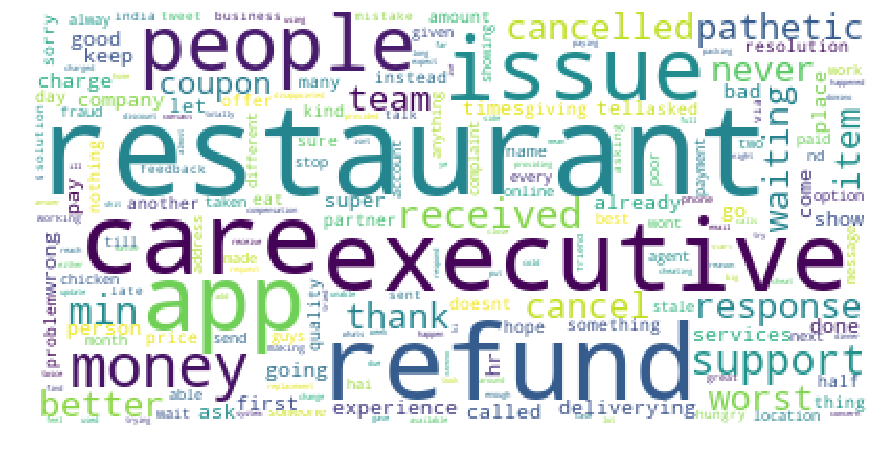

In [18]:
swiggy_word_tokens = word_tokenize(swiggy_corpus)
swiggy_corpus = ' '.join(swiggy_word_tokens)
cloud = WordCloud(background_color="white").generate(swiggy_corpus)

plt.figure(figsize=(15,15))
plt.imshow(cloud)

plt.axis('off')
plt.show()

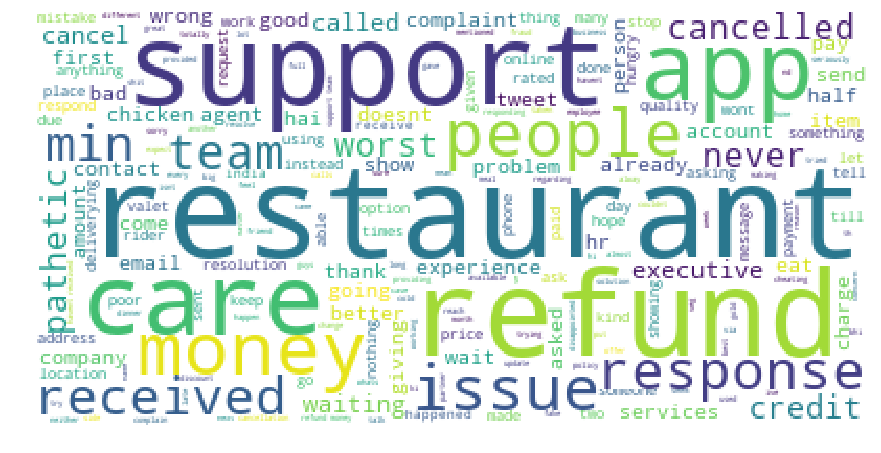

In [19]:
zomato_word_tokens = word_tokenize(zomato_corpus)
zomato_corpus = ' '.join(zomato_word_tokens)
cloud = WordCloud(background_color="white").generate(zomato_corpus)

plt.figure(figsize=(15,15))
plt.imshow(cloud)

plt.axis('off')
plt.show()

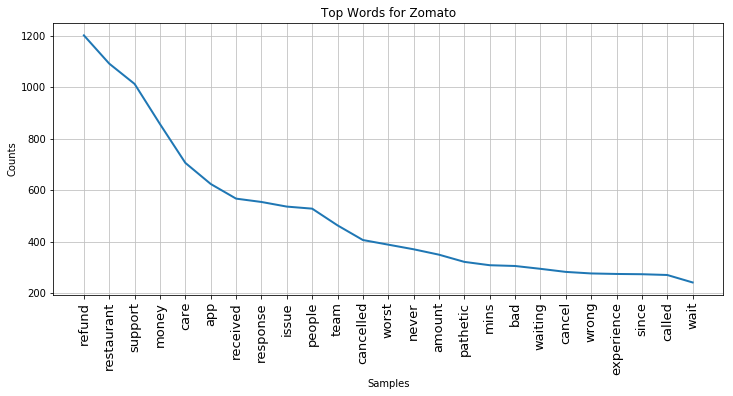

In [20]:
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(zomato_word_tokens)
fd.plot(25,cumulative=False, title='Top Words for Zomato')

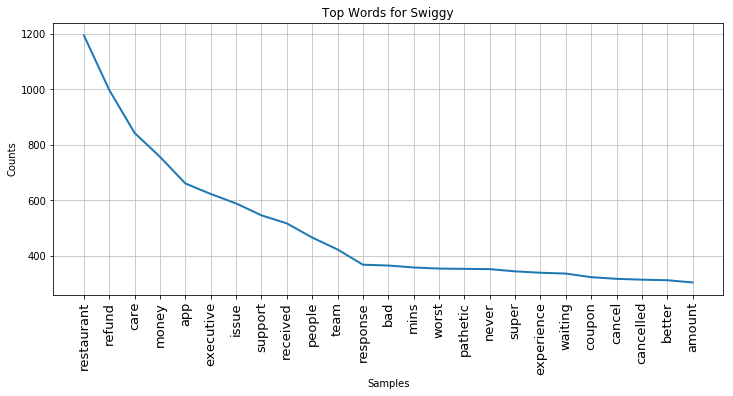

In [21]:
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(swiggy_word_tokens)
fd.plot(25,cumulative=False, title='Top Words for Swiggy')